# Weevil manuscript
Community assembly and diversification in a species‐rich radiation of island weevils (Coleoptera: Cratopini)
https://onlinelibrary.wiley.com/doi/abs/10.1111/jbi.13393

In [178]:
%matplotlib inline
%load_ext rpy2.ipython
import os

GIMME_DIR = "/home/isaac/gimmeSAD"
SIMOUT_DIR = GIMME_DIR + "/1d_sims/"
WEEVIL_WORKDIR = "/home/isaac/Continuosity/MESS/empirical_weevils/"
MAURITIUS_OBSERVED_FILE = os.path.join(WEEVIL_WORKDIR, "mauritius.obs")
REUNION_OBSERVED_FILE = os.path.join(WEEVIL_WORKDIR, "reunion.obs")

os.chdir(GIMME_DIR)
import gimmeSAD
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import random
import glob
import subprocess

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [271]:
FULL_REF_TABLE = os.path.join(SIMOUT_DIR, "full-priors.txt")
FULL_NORMED_REF_TABLE = os.path.join(SIMOUT_DIR, "full-normed-priors.txt")

force = True
ONEPER = True
REGULARIZE = False
DROPEQUILIBSIMS = False

def construct_full_prior(outfile, ONEPER=False, REGULARIZE=False):
    outfile = open(outfile, "w")
    files = glob.glob(SIMOUT_DIR + "*/sumstats.txt")
    numsims = 0
    outfile.write(open(files[0]).readlines()[0])
    for f in files:
        lines = open(f).readlines()[1:]
        new_lines = []
        for line in lines:
            try:
                ## DO or don't regularlize the histograms
                if REGULARIZE:
                    hist = np.array([int(x) for x in line.split()[7:]])
                    if np.sum(hist):
                        tot = np.sum(hist)
                        hist = hist/float(tot)
                    tmp = line.split()[:7] + map(str,hist)
                    line = "\t".join(tmp) + "\n"

                ## Do or don't drop all the extra sims at equilibrium
                if line.split()[3] == "1" and DROPEQUILIBSIMS:
                    pass
                else:
                    new_lines.append(line)
            except:
                pass
        lines = new_lines
        ## Only choose one step per simulation?
        if lines and ONEPER:
            lines = [random.choice(lines).strip()]

        ## Don't write blanks
        if lines:
            numsims += len(lines)
            lines[-1] = lines[-1].strip()
            outfile.write("".join(lines))
            outfile.write("\n")
    outfile.close()

    print("Processed {} simulations".format(numsims))

if not os.path.exists(FULL_REF_TABLE) or force:
    construct_full_prior(FULL_REF_TABLE, ONEPER=ONEPER)
if not os.path.exists(FULL_NORMED_REF_TABLE) or force:
    construct_full_prior(FULL_NORMED_REF_TABLE, ONEPER=ONEPER, REGULARIZE=True)

Processed 7473733 simulations
Processed 7473733 simulations


min bin size 10267


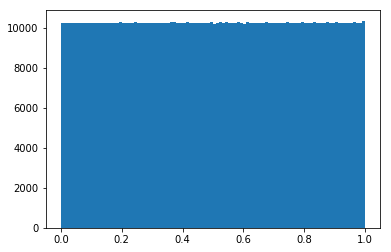

In [272]:
import sys
UNIF_FULL_REF_TABLE = os.path.join(SIMOUT_DIR, "uniform-full-priors.txt")
UNIF_FULL_NORMED_REF_TABLE = os.path.join(SIMOUT_DIR, "uniform-full-normed-priors.txt")

def uniform_lambda_prior(intable, outtable):
    dat = pd.read_csv(intable, sep="\t")

    ## Find min bin size
    gt_val = 0.01
    minct = len(dat[dat['%equil'] < gt_val])
    for lt_val in np.arange(0.02, 1.01, .01):
        gt = dat["%equil"] > gt_val
        lt = dat["%equil"] < lt_val
        gt_val = lt_val
        ct = len(dat[lt & gt])
        if ct < minct:
            minct = ct
    print("min bin size {}".format(minct))

    gt_val = 0.01
    outdf = dat[dat['%equil'] < gt_val].sample(n=minct, replace=False)
    for lt_val in np.arange(0.02, 1.01, .01):
        gt = dat["%equil"] > gt_val
        lt = dat["%equil"] < lt_val
        gt_val = lt_val
        try:
            samps = dat[lt & gt]
            ## Watch this, it'll bite you with the replacement.
            tmpdf = samps.sample(n=minct, replace=False)
        except:
            print(lt_val, len(samps))
        outdf = pd.concat([outdf, tmpdf])
    #outdf
    _, _, _ = plt.hist(outdf["%equil"], bins=100)
    outdf.to_csv(outtable, sep="\t", index=False)
uniform_lambda_prior(FULL_REF_TABLE, UNIF_FULL_REF_TABLE)
#uniform_lambda_prior(FULL_NORMED_REF_TABLE, UNIF_FULL_NORMED_REF_TABLE)

In [273]:
%%R -i MAURITIUS_OBSERVED_FILE -i REUNION_OBSERVED_FILE -i UNIF_FULL_NORMED_REF_TABLE -i UNIF_FULL_REF_TABLE
library(abc)

M_OBS<- read.table(MAURITIUS_OBSERVED_FILE, header=TRUE)
R_OBS<- read.table(REUNION_OBSERVED_FILE, header=TRUE)

## Do or don't regularize the observed pi bins
if(FALSE){
    tot = sum(M_OBS)
    OBS = data.frame(c(M_OBS/tot))
    M_OBS = OBS
    tot = sum(R_OBS)
    OBS = data.frame(c(R_OBS/tot))
    R_OBS = OBS
    PRIOR <- read.table(UNIF_FULL_NORMED_REF_TABLE, header=TRUE, fill=TRUE)
} else {
    PRIOR <- read.table(UNIF_FULL_REF_TABLE, header=TRUE, fill=TRUE)
}

## fill adds NA for any incomplete row

print(PRIOR[1,])
print(M_OBS)
print(R_OBS)

     K            c     step     X.equil      colrate      extrate  shannon
1 4462 0.0001225733 85170000 0.005826983 0.0001100622 0.0001100035 1.464333
  bin_0 bin_1 bin_2 bin_3 bin_4 bin_5 bin_6 bin_7 bin_8 bin_9
1     1     0     1     2     0     0     0     0     0     1
  bin_0 bin_1 bin_2 bin_3 bin_4 bin_5 bin_6 bin_7 bin_8 bin_9
1     4     5     1     6     1     0     0     0     1     1
  bin_0 bin_1 bin_2 bin_3 bin_4 bin_5 bin_6 bin_7 bin_8 bin_9
1     0     4     2     3     3     0     0     1     0     1


## ABC CV

Prediction error based on a cross-validation sample of 10

              eq
0.001  0.9633978
0.0025 0.8012816
0.005  0.7350364


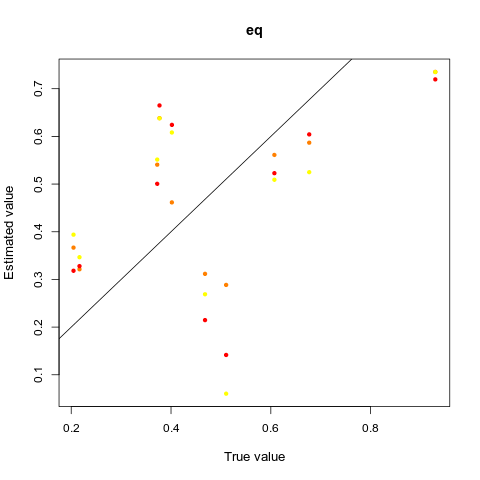

In [141]:
%%R
cv.res.rej <- cv4abc(data.frame(eq=PRIOR[,"X.equil"]), PRIOR[,8:17], nval=10, tols=c(0.001,.0025,.005), method="rejection")
print(summary(cv.res.rej))
plot(cv.res.rej)

In [274]:
%%R
mauritius_eqil.abc = abc(target=M_OBS, param=data.frame(eq=PRIOR[,"X.equil"]), sumstat=PRIOR[,8:17], tol=0.0005,
                  hcorr=FALSE, method="rejection", lambda=1, numnet=5, sizenet=30)
print(summary(mauritius_eqil.abc))
hist(mauritius_eqil.abc)
plot(mauritius_eqil.abc, param=PRIOR[,"X.equil"])



Call: 
abc(target = M_OBS, param = data.frame(eq = PRIOR[, "X.equil"]), 
    sumstat = PRIOR[, 8:17], tol = 5e-04, method = "rejection", 
    hcorr = FALSE, numnet = 5, sizenet = 30, lambda = 1)
Data:
 abc.out$unadj.values (514 posterior samples)

                 eq
Min.:        0.0343
2.5% Perc.:  0.0968
Median:      0.7341
Mean:        0.6534
Mode:        0.8595
97.5% Perc.: 0.9854
Max.:        0.9993
                     eq
Min.:        0.03431764
2.5% Perc.:  0.09684812
Median:      0.73408362
Mean:        0.65341151
Mode:        0.85950058
97.5% Perc.: 0.98537314
Max.:        0.99934124
Error in plot.abc(mauritius_eqil.abc, param = PRIOR[, "X.equil"]) : 
  Diagnostic plots can be displayed only when method is "loclinear", "neuralnet" or "ridge".FALSE


In [275]:
%%R
reunion_eqil.abc = abc(target=R_OBS, param=data.frame(eq=PRIOR[,"X.equil"]), sumstat=PRIOR[,8:17], tol=0.0005,
                  hcorr=FALSE, method="rejection", lambda=1, numnet=5, sizenet=30)
print(summary(reunion_eqil.abc))
hist(reunion_eqil.abc)
plot(reunion_eqil.abc, param=PRIOR[,"X.equil"])


Call: 
abc(target = R_OBS, param = data.frame(eq = PRIOR[, "X.equil"]), 
    sumstat = PRIOR[, 8:17], tol = 5e-04, method = "rejection", 
    hcorr = FALSE, numnet = 5, sizenet = 30, lambda = 1)
Data:
 abc.out$unadj.values (514 posterior samples)

                 eq
Min.:        0.0063
2.5% Perc.:  0.0927
Median:      0.6046
Mean:        0.5604
Mode:        0.7833
97.5% Perc.: 0.8952
Max.:        0.9195
                      eq
Min.:        0.006252171
2.5% Perc.:  0.092699140
Median:      0.604636773
Mean:        0.560415215
Mode:        0.783349073
97.5% Perc.: 0.895236205
Max.:        0.919480153
Error in plot.abc(reunion_eqil.abc, param = PRIOR[, "X.equil"]) : 
  Diagnostic plots can be displayed only when method is "loclinear", "neuralnet" or "ridge".FALSE


0.6534115108981745
[0.13151575 0.98936416]


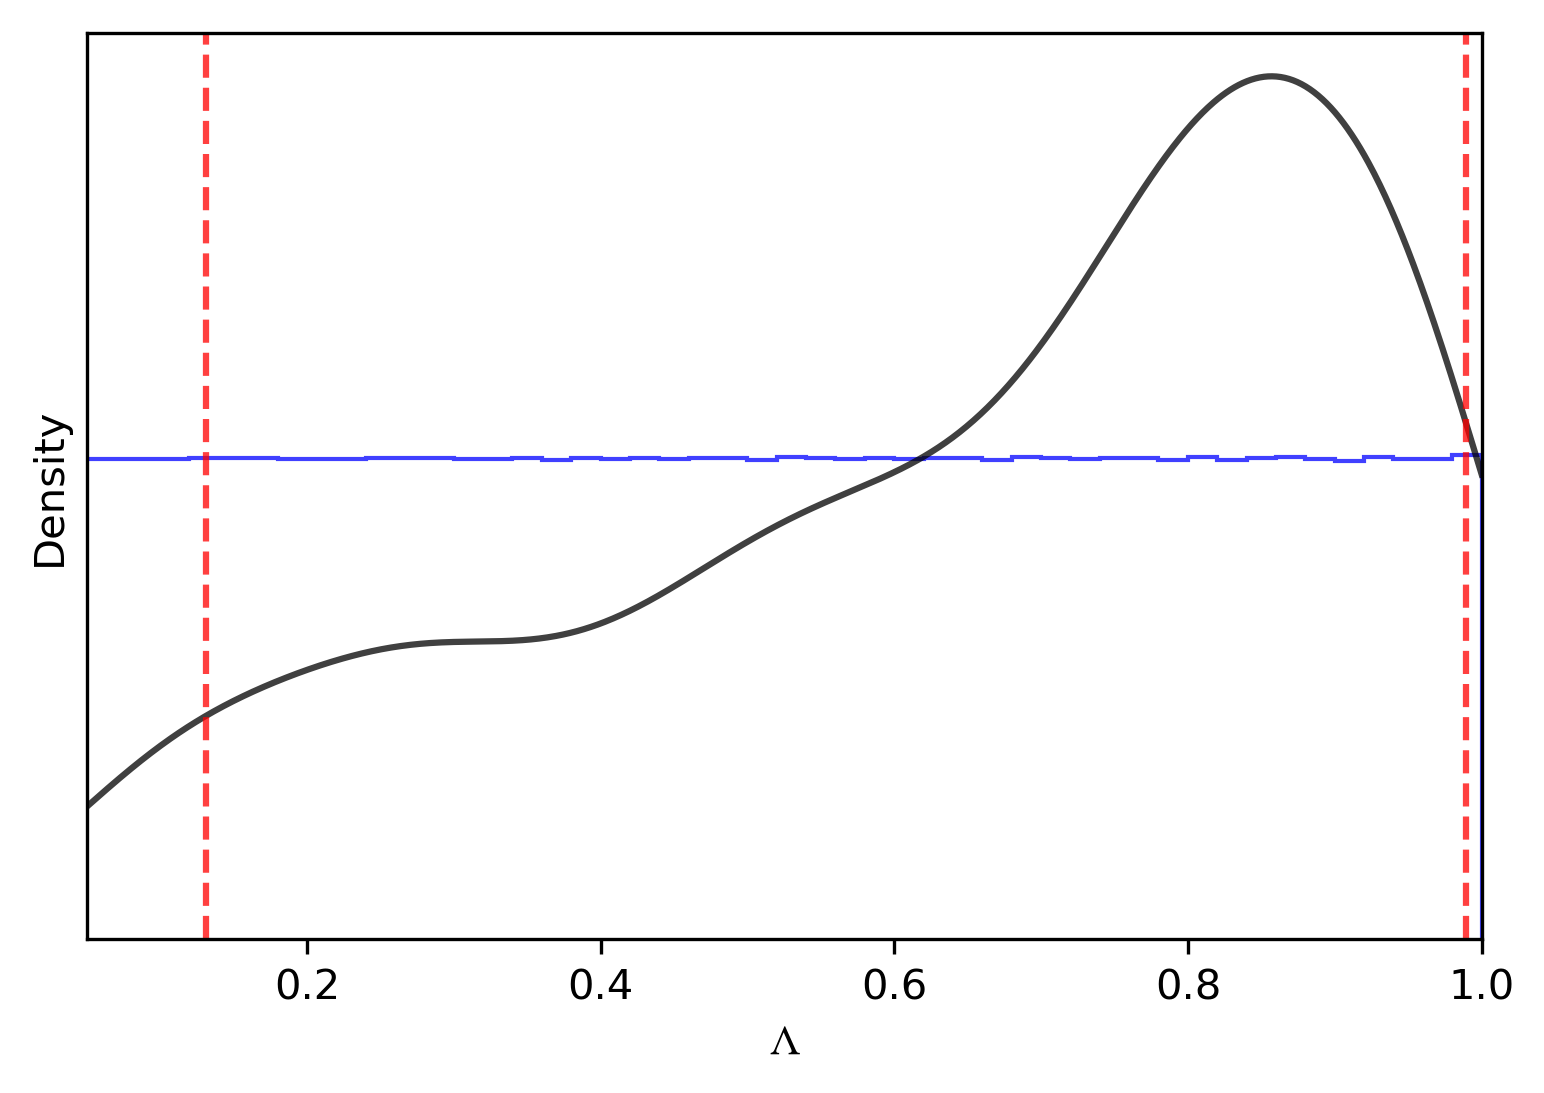

In [276]:
%R -o m_out m_out=mauritius_eqil.abc
from sklearn.decomposition import PCA
import scipy
import matplotlib.pyplot as plt
import pymc3
import matplotlib
from matplotlib.font_manager import FontProperties
matplotlib.font_manager._rebuild()

out = m_out

## Get lambda prior
f = open(REF_TABLE).readlines()
lines = [line.split("\t") for line in f]
lamb_dat = []
for line in lines:
    try:
        lamb_dat.append(float(line[3]))
    except:
        pass
#n, bins, patches = plt.hist(lamb_dat, bins=50, histtype="step", normed=True)

## Read in observed data

#print(out.shape)
eqs = np.array(out[0])
eqs = eqs[eqs <= 1.0]
print(np.mean(eqs))
fig = plt.figure(dpi=300)
plt.rcParams["font.family"] = "Helvetica"

ax = fig.gca()
ax.get_yaxis().set_ticks([])

## Histogram of posterior samples
#_, _, _ = plt.hist(eqs, bins=75, color='grey', lw=1, normed=True)

## KDE
X_plot = np.linspace(0.05, 1, 1000)
kde = scipy.stats.gaussian_kde(eqs)
plt.plot(X_plot, kde(X_plot), alpha=0.75, color='black')

## HPD
xs = pymc3.stats.hpd(eqs)
print(xs)
plt.axvline(xs[0], color='r', linestyle='--', alpha=0.75)
plt.axvline(xs[1], color='r', linestyle='--', alpha=0.75)

font = FontProperties()
font.set_family('Times New Roman')
plt.xlabel(u"Λ", fontproperties=font)
plt.ylabel(u"Density")
## Truncate to show all or part of prior
plt.xlim((0.05, 1))
_, _, _ = plt.hist(lamb_dat, bins=50, histtype="step", normed=True, color='b', alpha=0.75)
#plt.savefig("/home/isaac/gimmeSAD/spider-both-equilib-posterior.svg")

0.5604152147247622
[0.14388489 0.91948015]


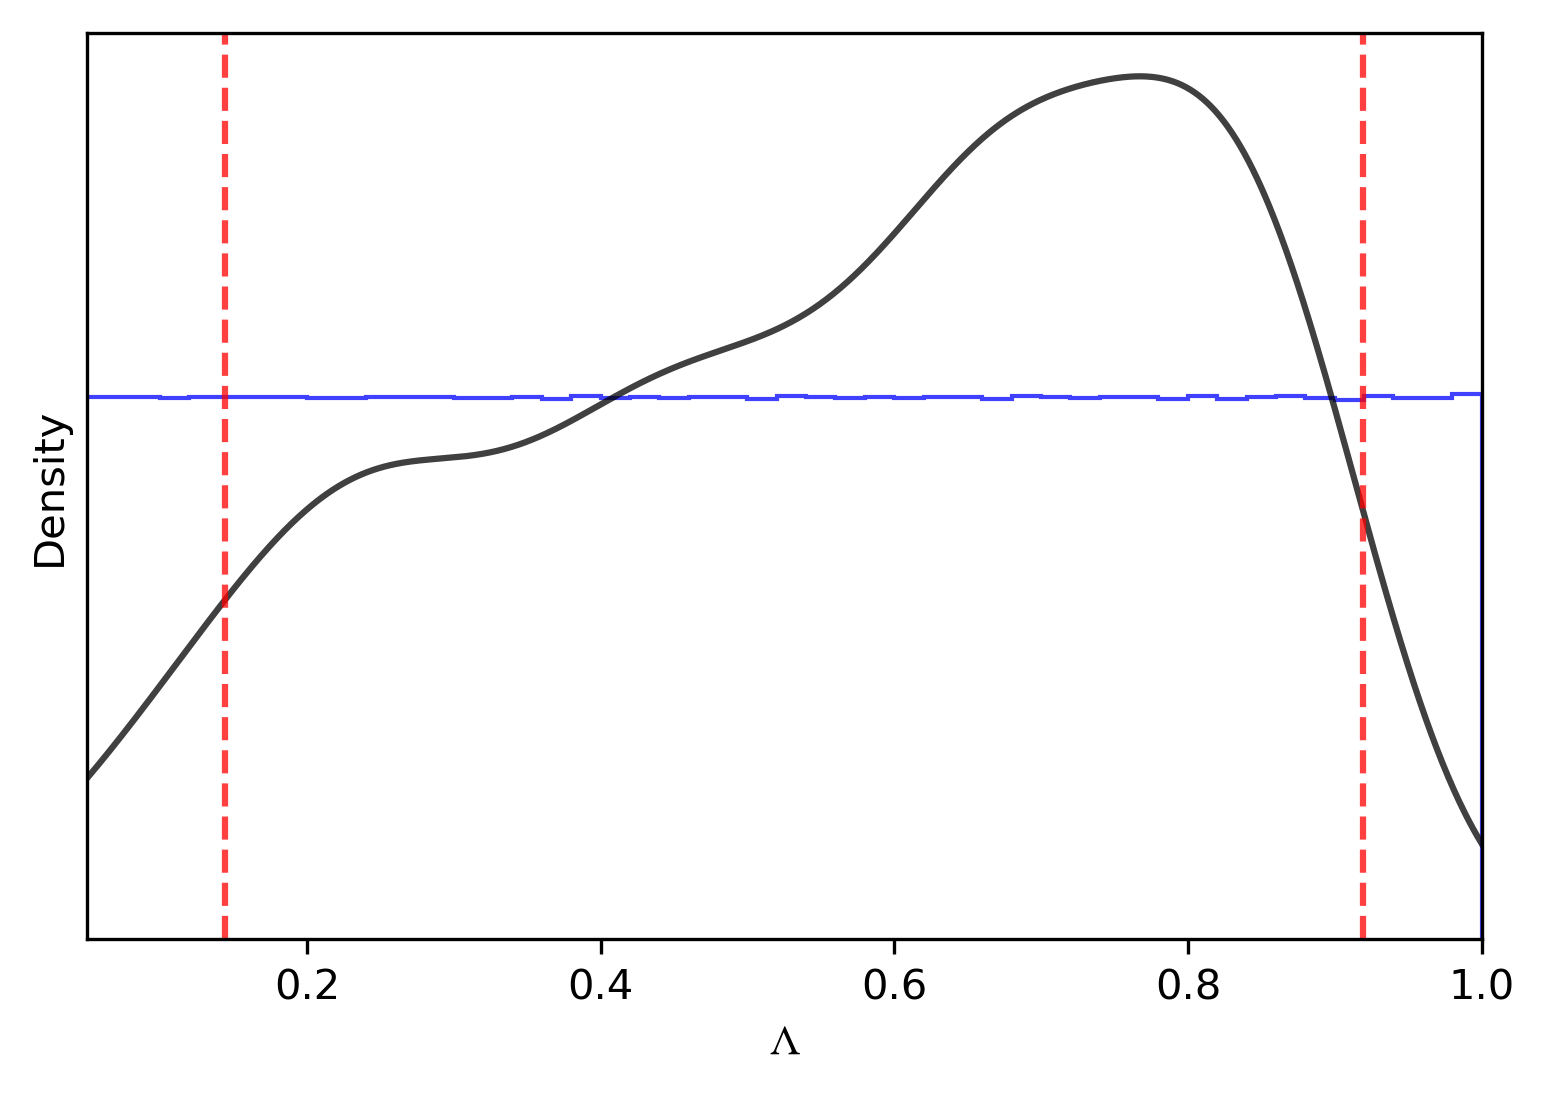

In [293]:
%R -o r_out r_out=reunion_eqil.abc
from sklearn.decomposition import PCA
import scipy
import matplotlib.pyplot as plt
import pymc3
import matplotlib
from matplotlib.font_manager import FontProperties
matplotlib.font_manager._rebuild()

out = r_out

## Get lambda prior
f = open(REF_TABLE).readlines()
lines = [line.split("\t") for line in f]
lamb_dat = []
for line in lines:
    try:
        lamb_dat.append(float(line[3]))
    except:
        pass
#n, bins, patches = plt.hist(lamb_dat, bins=50, histtype="step", normed=True)

## Read in observed data

#print(out.shape)
eqs = np.array(out[0])
eqs = eqs[eqs <= 1.0]
print(np.mean(eqs))
fig = plt.figure(dpi=300)
plt.rcParams["font.family"] = "Helvetica"

ax = fig.gca()
ax.get_yaxis().set_ticks([])

## Histogram of posterior samples
#_, _, _ = plt.hist(eqs, bins=75, color='grey', lw=1, normed=True)

## KDE
X_plot = np.linspace(0.05, 1, 1000)
kde = scipy.stats.gaussian_kde(eqs)
plt.plot(X_plot, kde(X_plot), alpha=0.75, color='black')

## HPD
xs = pymc3.stats.hpd(eqs)
print(xs)
plt.axvline(xs[0], color='r', linestyle='--', alpha=0.75)
plt.axvline(xs[1], color='r', linestyle='--', alpha=0.75)

font = FontProperties()
font.set_family('Times New Roman')
plt.xlabel(u"Λ", fontproperties=font)
plt.ylabel(u"Density")
## Truncate to show all or part of prior
plt.xlim((0.05, 1))
_, _, _ = plt.hist(lamb_dat, bins=50, histtype="step", normed=True, color='b', alpha=0.75)
#plt.savefig("/home/isaac/gimmeSAD/spider-both-equilib-posterior.svg")

0.5604152147247622
0.6534115108981745


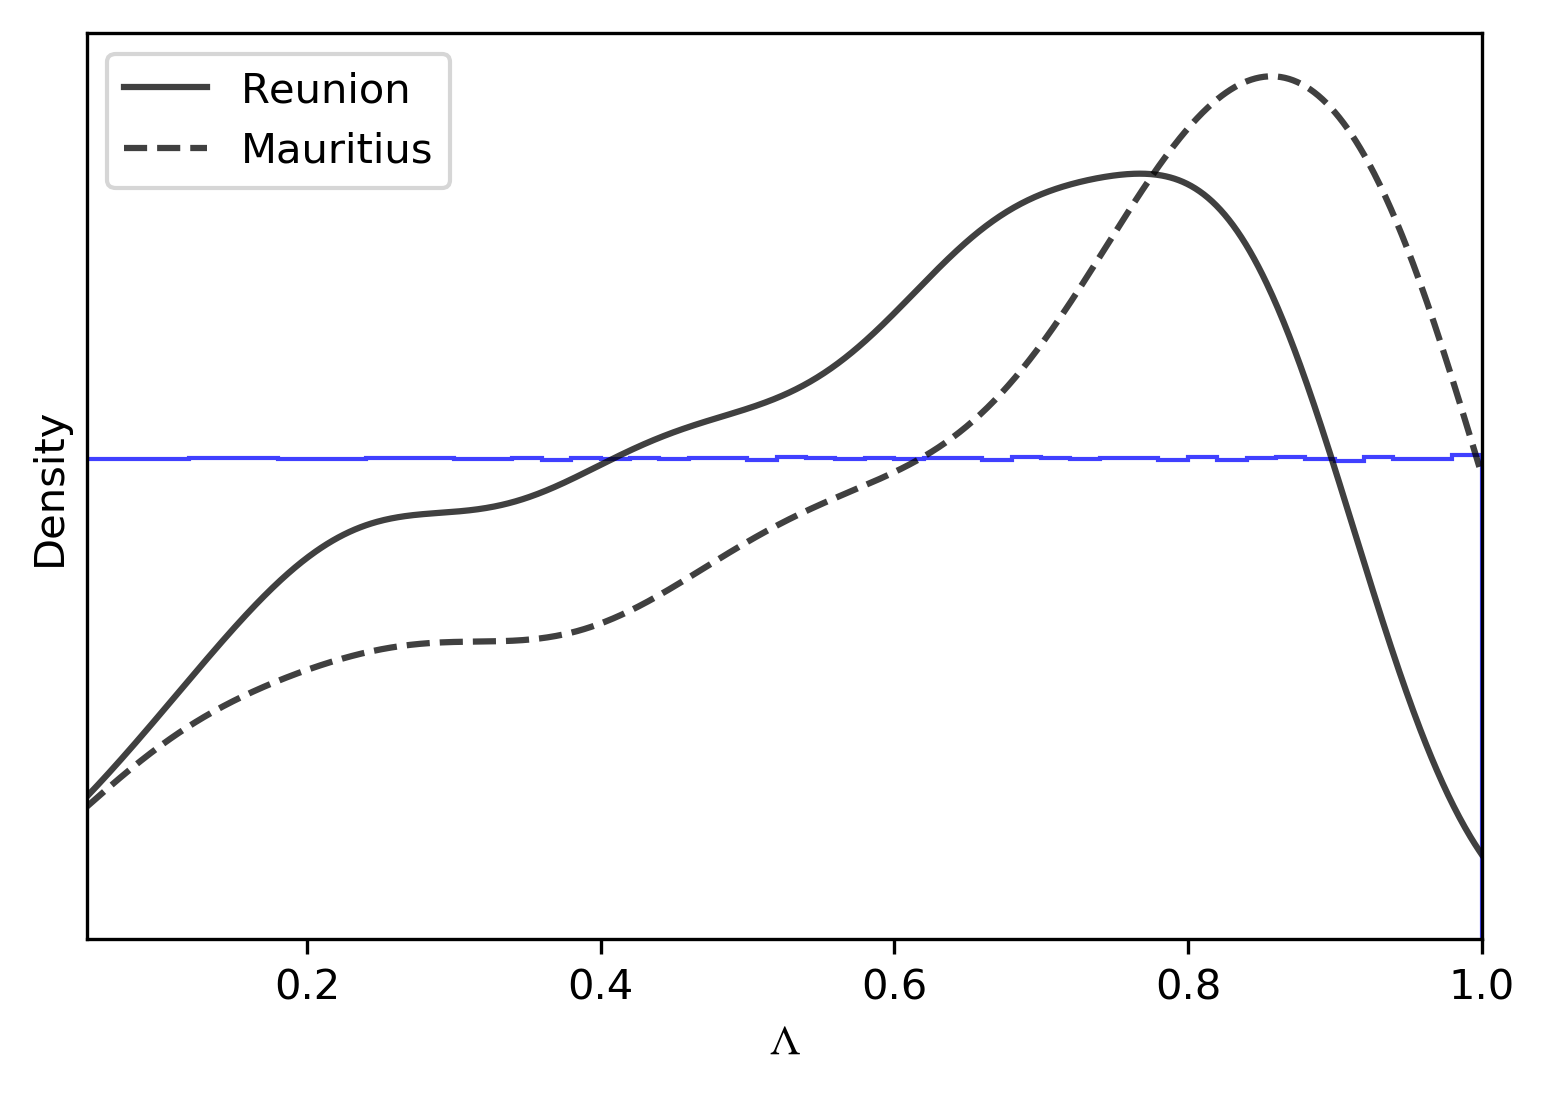

In [298]:
%R -o rout rout=reunion_eqil.abc
%R -o mout mout=mauritius_eqil.abc

from sklearn.decomposition import PCA
import scipy
import matplotlib.pyplot as plt
import pymc3
import matplotlib
from matplotlib.font_manager import FontProperties
matplotlib.font_manager._rebuild()

## Get lambda prior
f = open(REF_TABLE).readlines()
lines = [line.split("\t") for line in f]
lamb_dat = []
for line in lines:
    try:
        lamb_dat.append(float(line[3]))
    except:
        pass
#n, bins, patches = plt.hist(lamb_dat, bins=50, histtype="step", normed=True)

## Read in observed data

#print(out.shape)
reqs = np.array(rout[0])
reqs = reqs[eqs <= 1.0]
reqs = reqs[~np.isnan(reqs)]
print(np.mean(reqs))

meqs = np.array(mout[0])
meqs = meqs[meqs <= 1.0]
print(np.mean(meqs))

fig = plt.figure(dpi=300)
plt.rcParams["font.family"] = "Helvetica"

ax = fig.gca()
ax.get_yaxis().set_ticks([])

## Histogram of posterior samples
#_, _, _ = plt.hist(eqs, bins=75, color='grey', lw=1, normed=True)

## KDE
X_plot = np.linspace(0.05, 1, 1000)
kde = scipy.stats.gaussian_kde(reqs)
plt.plot(X_plot, kde(X_plot), alpha=0.75, color='black', label="Reunion")

kde = scipy.stats.gaussian_kde(meqs)
plt.plot(X_plot, kde(X_plot), alpha=0.75, color='black', linestyle="--", label="Mauritius")

## HPD
#xs = pymc3.stats.hpd(eqs)
#print(xs)
#plt.axvline(xs[0], color='r', linestyle='--', alpha=0.75)
#plt.axvline(xs[1], color='r', linestyle='--', alpha=0.75)

font = FontProperties()
font.set_family('Times New Roman')
plt.xlabel(u"Λ", fontproperties=font)
plt.ylabel(u"Density")
## Truncate to show all or part of prior
plt.xlim((0.05, 1))
_, _, _ = plt.hist(lamb_dat, bins=50, histtype="step", normed=True, color='b', alpha=0.75)
plt.legend()
#plt.savefig("/home/isaac/gimmeSAD/spider-both-equilib-posterior.svg")

[4 5 1 6 1 0 0 0 1 1]
(10,)
(514, 10)
[[4. 6. 2. 4. 0. 0. 0. 0. 1. 1.]
 [3. 6. 2. 5. 1. 0. 1. 0. 0. 1.]]
(515, 10)
[4. 5. 1. 6. 1. 0. 0. 0. 1. 1.]
explained variance ratio (first two components): [0.22399943 0.21175126]


[]

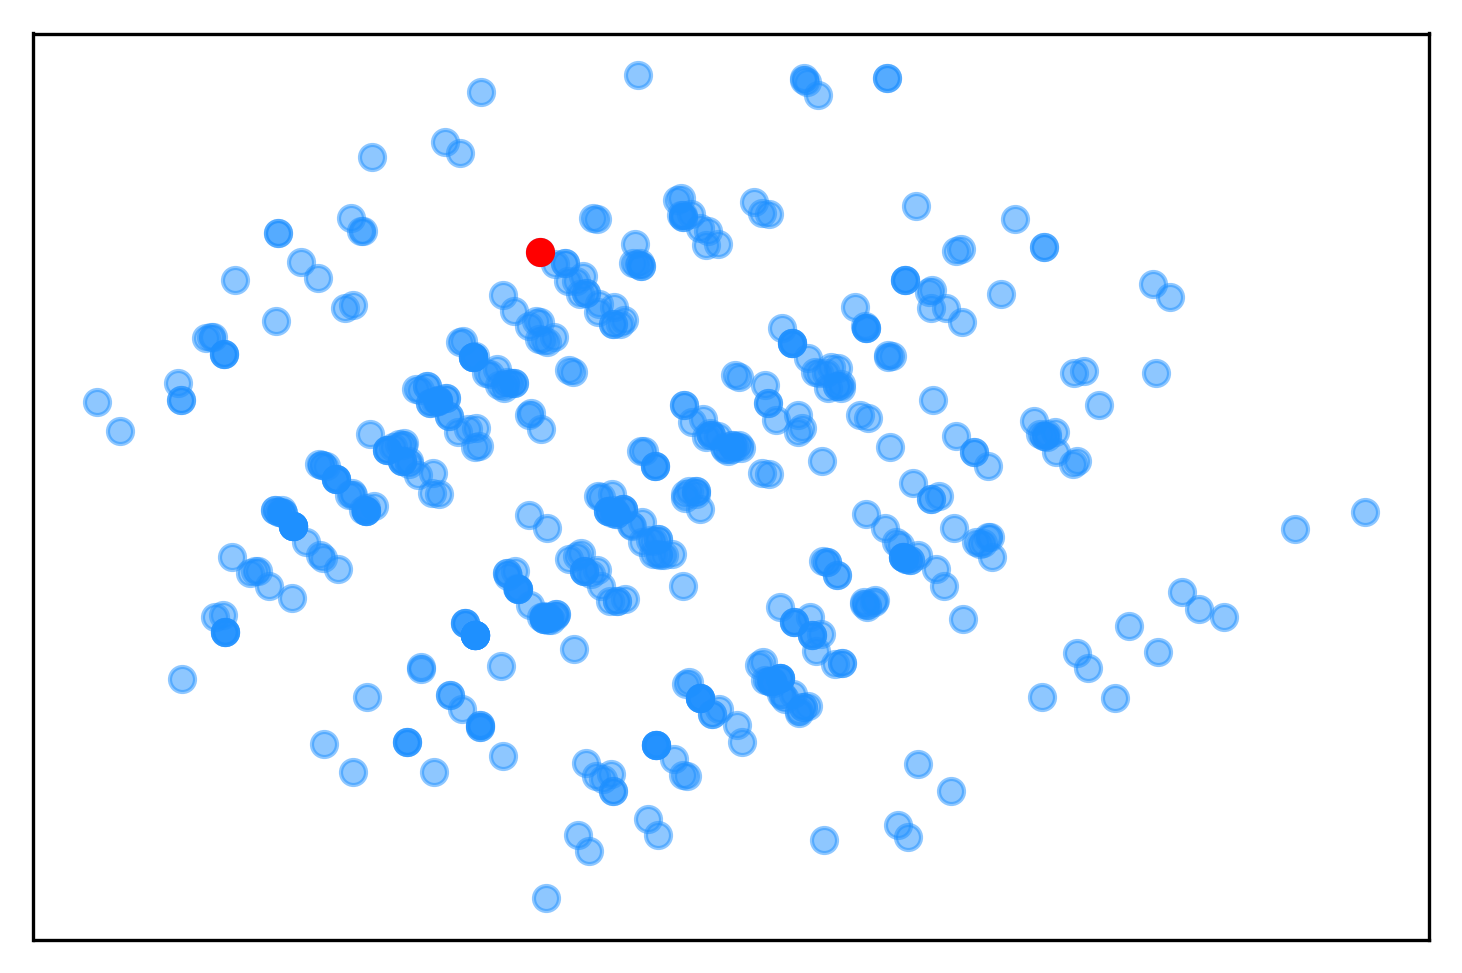

In [278]:
%R -o out out=mauritius_eqil.abc$ss
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

## Read in observed data
## `split()[2:]` drops the H' and the first bin, implementing a veil line
OBS = np.array([int(x) for x in open(MAURITIUS_OBSERVED_FILE).readlines()[1].split()])
print(OBS)
print(OBS.shape)
print(out.shape)
print(out[0:2])
#out = np.delete(out, 0, axis=1)

dat = np.vstack([out, OBS])
print(dat.shape)
print(dat[-1])
pca = PCA(n_components=2)
X_r = pca.fit(out).transform(out)
print('explained variance ratio (first two components): %s'
      % str(pca.explained_variance_ratio_))
plt.figure(dpi=300)
x, y = zip(*X_r)
plt.scatter(x, y, color='DodgerBlue', lw=1, alpha=0.5)
plt.scatter(x[-1], y[-1], c="r")

ax = plt.gca()
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])

[0 4 2 3 3 0 0 1 0 1]
(10,)
(514, 10)
[[1. 3. 3. 2. 3. 0. 0. 0. 0. 1.]
 [0. 4. 2. 3. 2. 0. 0. 0. 0. 1.]]
(515, 10)
[0. 4. 2. 3. 3. 0. 0. 1. 0. 1.]
explained variance ratio (first two components): [0.2378785  0.18069853]


[]

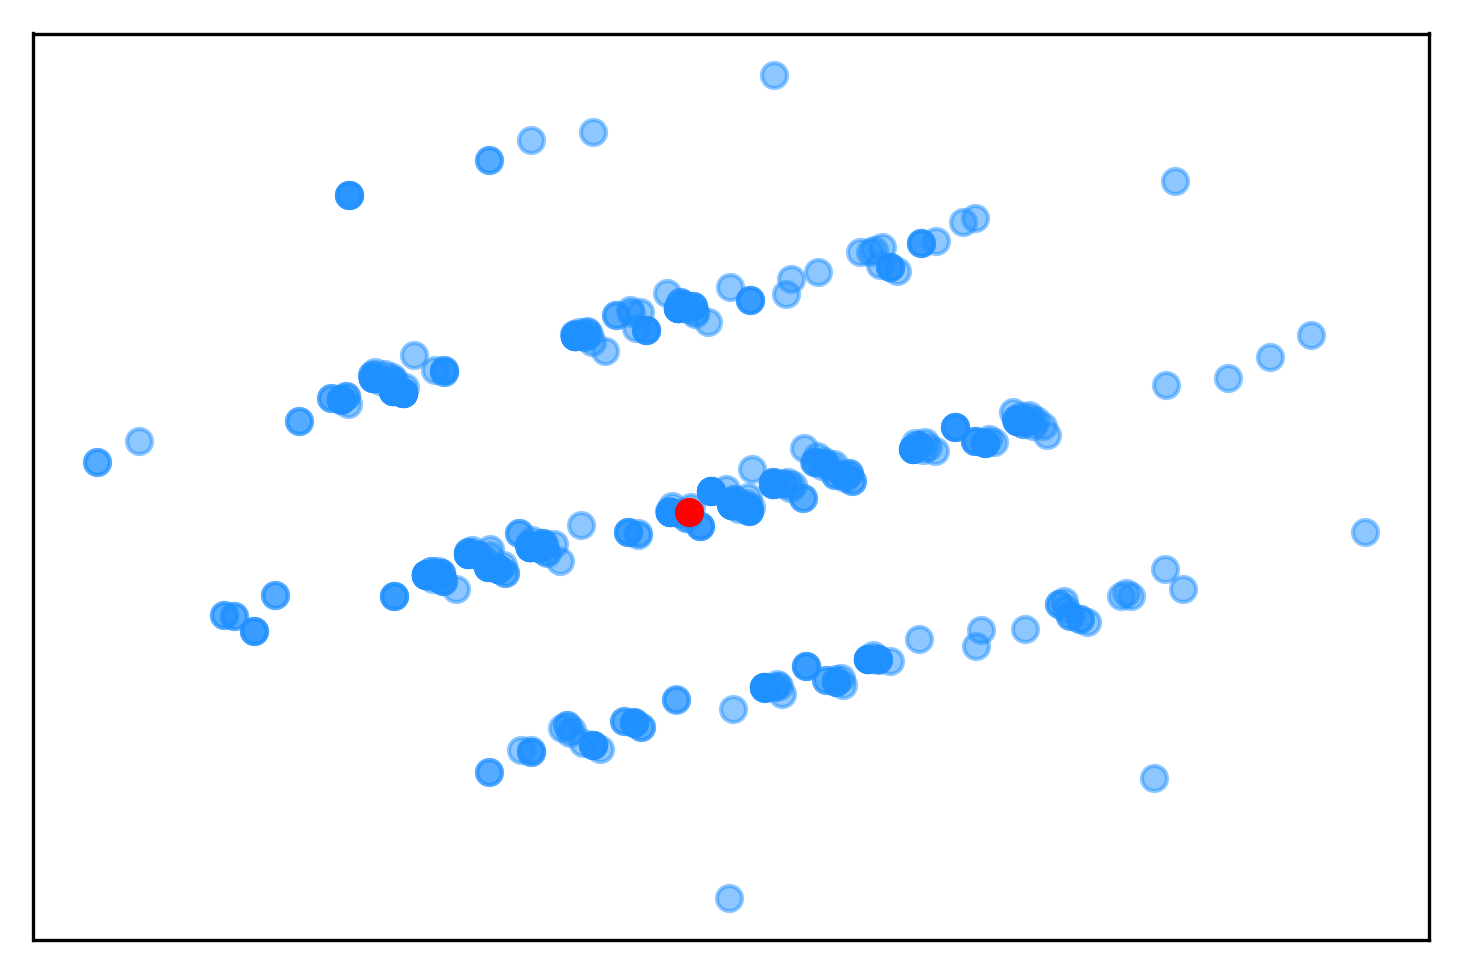

In [279]:
%R -o out out=reunion_eqil.abc$ss
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

## Read in observed data
## `split()[2:]` drops the H' and the first bin, implementing a veil line
OBS = np.array([int(x) for x in open(REUNION_OBSERVED_FILE).readlines()[1].split()])
print(OBS)
print(OBS.shape)
print(out.shape)
print(out[0:2])
#out = np.delete(out, 0, axis=1)

dat = np.vstack([out, OBS])
print(dat.shape)
print(dat[-1])
pca = PCA(n_components=2)
X_r = pca.fit(out).transform(out)
print('explained variance ratio (first two components): %s'
      % str(pca.explained_variance_ratio_))
plt.figure(dpi=300)
x, y = zip(*X_r)
plt.scatter(x, y, color='DodgerBlue', lw=1, alpha=0.5)
plt.scatter(x[-1], y[-1], c="r")

ax = plt.gca()
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])

Call: 
abc(target = R_OBS, param = data.frame(shan = PRIOR[, "shannon"]), 
    sumstat = PRIOR[, 8:17], tol = 5e-04, method = "rejection", 
    numnet = 30, lambda = 0.01)
Data:
 abc.out$unadj.values (514 posterior samples)

               shan
Min.:        1.2050
2.5% Perc.:  1.4351
Median:      2.1602
Mean:        2.1465
Mode:        2.2671
97.5% Perc.: 2.7287
Max.:        3.0200
                 shan
Min.:        1.205018
2.5% Perc.:  1.435134
Median:      2.160162
Mean:        2.146459
Mode:        2.267126
97.5% Perc.: 2.728689
Max.:        3.020039
Call: 
abc(target = M_OBS, param = data.frame(shan = PRIOR[, "shannon"]), 
    sumstat = PRIOR[, 8:17], tol = 5e-04, method = "rejection", 
    numnet = 30, lambda = 0.01)
Data:
 abc.out$unadj.values (514 posterior samples)

               shan
Min.:        1.4508
2.5% Perc.:  1.8272
Median:      2.4860
Mean:        2.4729
Mode:        2.4692
97.5% Perc.: 2.9833
Max.:        3.3614
                 shan
Min.:        1.450772
2.5% Perc.

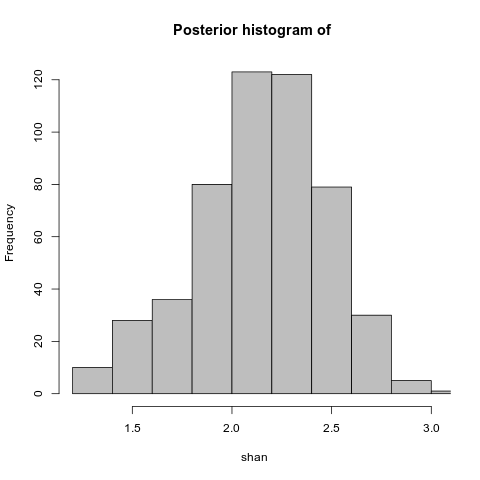

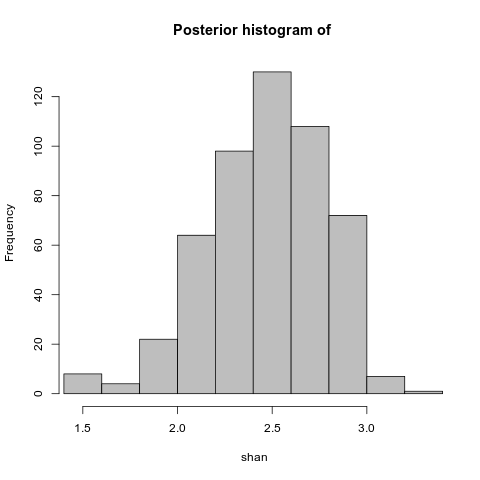

In [280]:
%%R
reunion_shan.abc = abc(target=R_OBS, param=data.frame(shan=PRIOR[,"shannon"]), sumstat=PRIOR[,8:17],
                tol=0.0005, method="rejection", numnet=30, lambda=0.01)
print(summary(reunion_shan.abc))
hist(reunion_shan.abc, cap="", breaks=10)

mauritius_shan.abc = abc(target=M_OBS, param=data.frame(shan=PRIOR[,"shannon"]), sumstat=PRIOR[,8:17],
                tol=0.0005, method="rejection", numnet=30, lambda=0.01)
print(summary(mauritius_shan.abc))
hist(mauritius_shan.abc, cap="", breaks=10)

2.472856479430681
[1.88391566 2.99520201]


Text(0,0.5,u'Density')

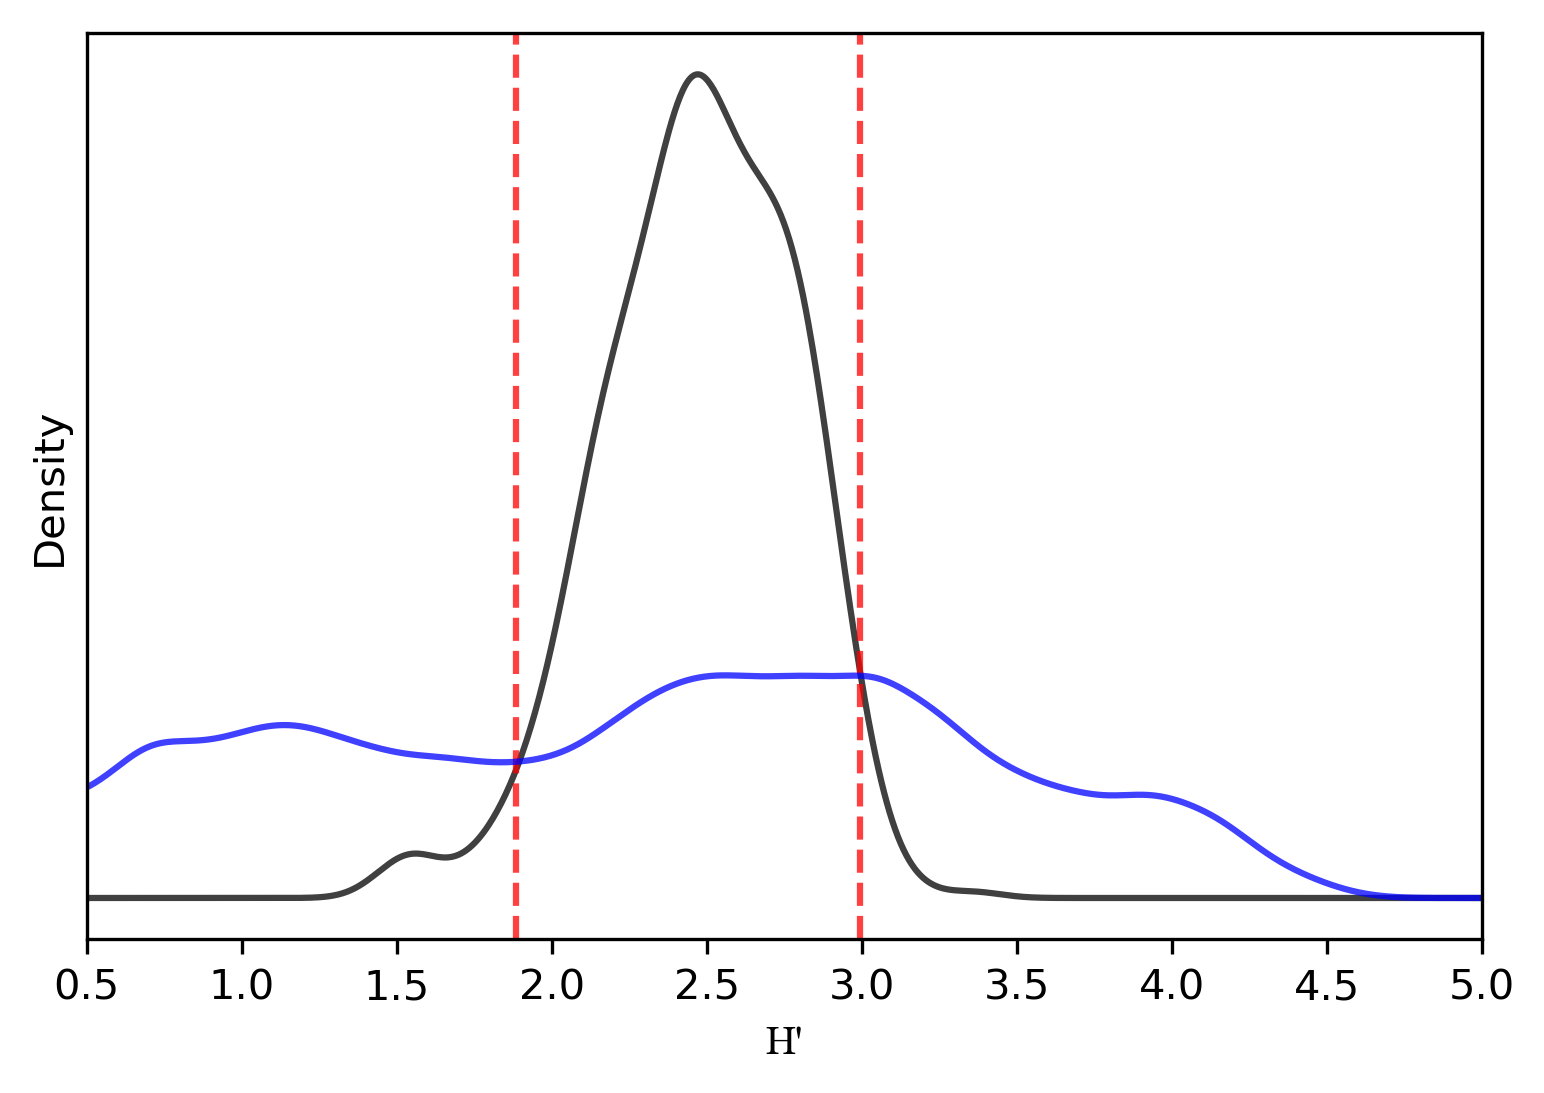

In [281]:
%R -o out out=mauritius_shan.abc
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pymc3
import scipy
import matplotlib
from matplotlib.font_manager import FontProperties
matplotlib.font_manager._rebuild()


## Get shannon prior
f = open(REF_TABLE).readlines()
lines = [line.split("\t") for line in f]

shan_dat = []
for line in lines:
    try:
        shan_dat.append(float(line[6]))
    except:
        pass

shans = np.array(out[0]).ravel()
print(np.mean(shans))
fig = plt.figure(dpi=300)
plt.rcParams["font.family"] = "Helvetica"

ax = fig.gca()
ax.get_yaxis().set_ticks([])
#_, _, _ = plt.hist(shans, bins=75, color='grey', lw=1, normed=True)

xmin = 0.5
xmax = 5
## KDE
X_plot = np.linspace(xmin, xmax, 1000)
kde = scipy.stats.gaussian_kde(shans)
plt.plot(X_plot, kde(X_plot), color='black', alpha=0.75)

xs = pymc3.stats.hpd(shans)
print(xs)
plt.axvline(xs[0], color='r', linestyle='--', alpha=0.75)
plt.axvline(xs[1], color='r', linestyle='--', alpha=0.75)
## Truncate to make it look nicer
plt.xlim((xmin, xmax))

#plt.hist(shan_dat, bins=100, histtype="step", normed=True, color='b', alpha=0.75)
X_plot = np.linspace(xmin, xmax, 1000)
kde = scipy.stats.gaussian_kde(shan_dat)
plt.plot(X_plot, kde(X_plot), color='blue', alpha=0.75)

font.set_family('Times New Roman')
plt.xlabel(u"H'", fontproperties=font)
plt.ylabel(u"Density")

#plt.savefig("/home/isaac/gimmeSAD/spider-shannon-posterior.svg")

2.146458898713852
[1.44025331 2.73165003]


Text(0,0.5,u'Density')

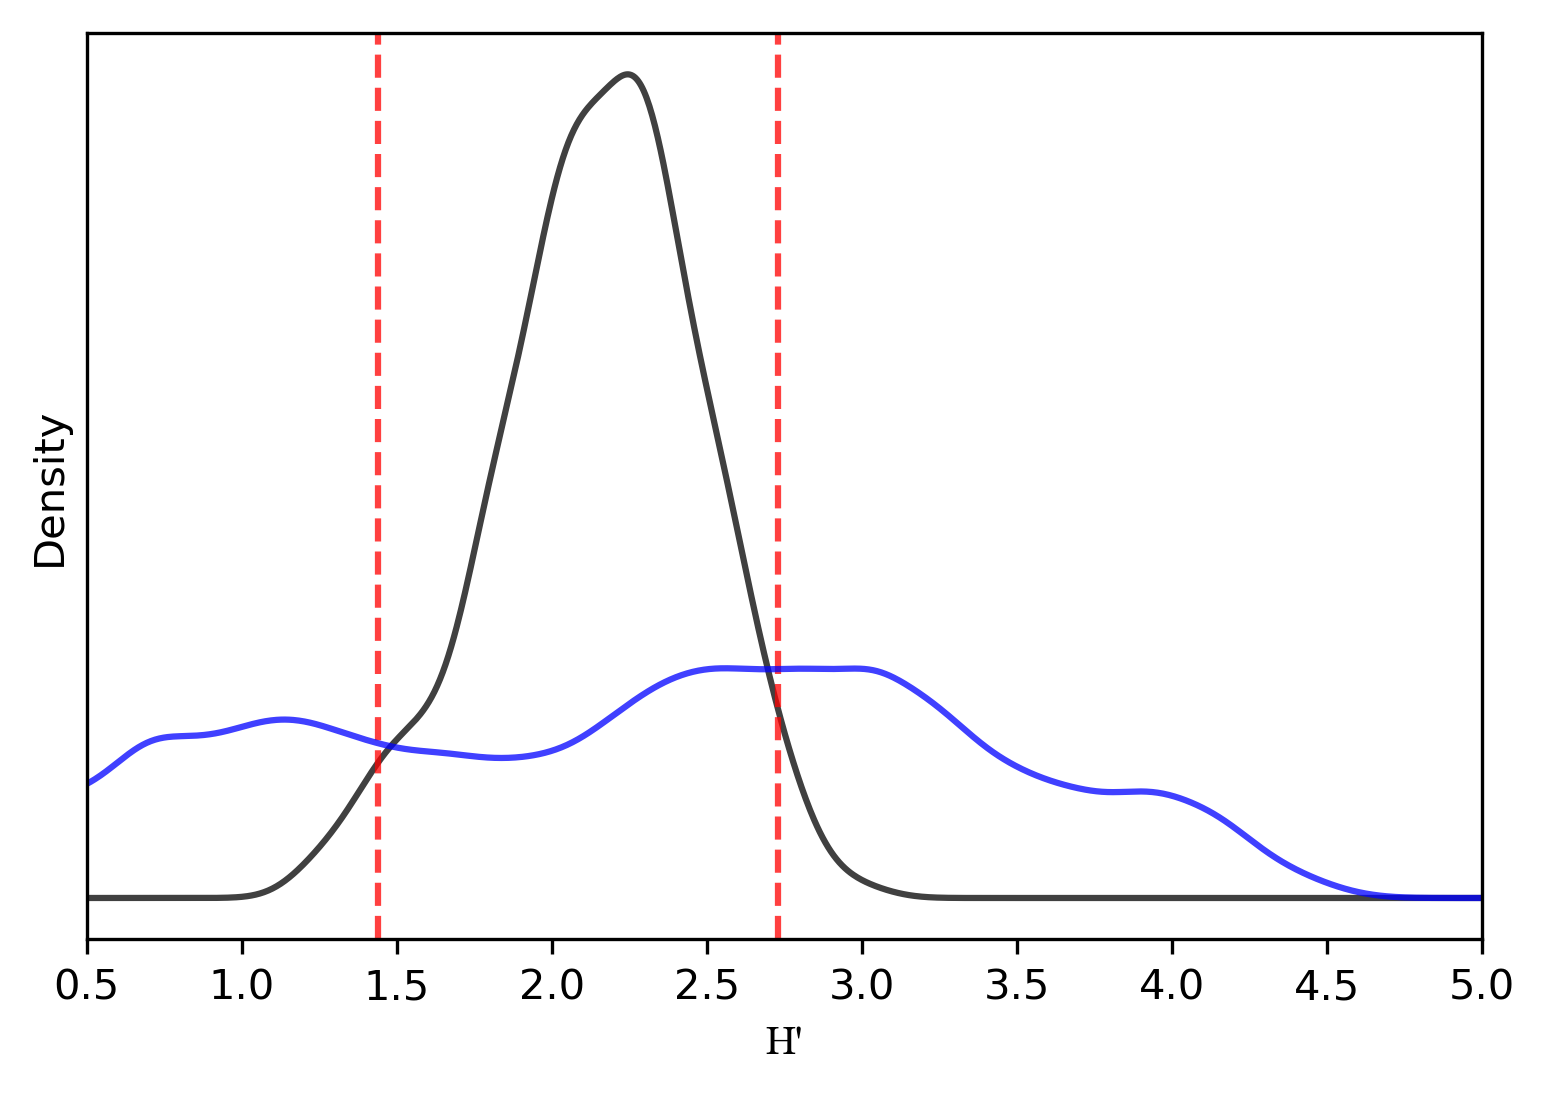

In [282]:
%R -o out out=reunion_shan.abc
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pymc3
import scipy
import matplotlib
from matplotlib.font_manager import FontProperties
matplotlib.font_manager._rebuild()


## Get shannon prior
f = open(REF_TABLE).readlines()
lines = [line.split("\t") for line in f]

shan_dat = []
for line in lines:
    try:
        shan_dat.append(float(line[6]))
    except:
        pass

shans = np.array(out[0]).ravel()
print(np.mean(shans))
fig = plt.figure(dpi=300)
plt.rcParams["font.family"] = "Helvetica"

ax = fig.gca()
ax.get_yaxis().set_ticks([])
#_, _, _ = plt.hist(shans, bins=75, color='grey', lw=1, normed=True)

xmin = 0.5
xmax = 5
## KDE
X_plot = np.linspace(xmin, xmax, 1000)
kde = scipy.stats.gaussian_kde(shans)
plt.plot(X_plot, kde(X_plot), color='black', alpha=0.75)

xs = pymc3.stats.hpd(shans)
print(xs)
plt.axvline(xs[0], color='r', linestyle='--', alpha=0.75)
plt.axvline(xs[1], color='r', linestyle='--', alpha=0.75)
## Truncate to make it look nicer
plt.xlim((xmin, xmax))

#plt.hist(shan_dat, bins=100, histtype="step", normed=True, color='b', alpha=0.75)
X_plot = np.linspace(xmin, xmax, 1000)
kde = scipy.stats.gaussian_kde(shan_dat)
plt.plot(X_plot, kde(X_plot), color='blue', alpha=0.75)

font.set_family('Times New Roman')
plt.xlabel(u"H'", fontproperties=font)
plt.ylabel(u"Density")

#plt.savefig("/home/isaac/gimmeSAD/spider-shannon-posterior.svg")

## Both H'

(2.146458898713852, 2.472856479430681)


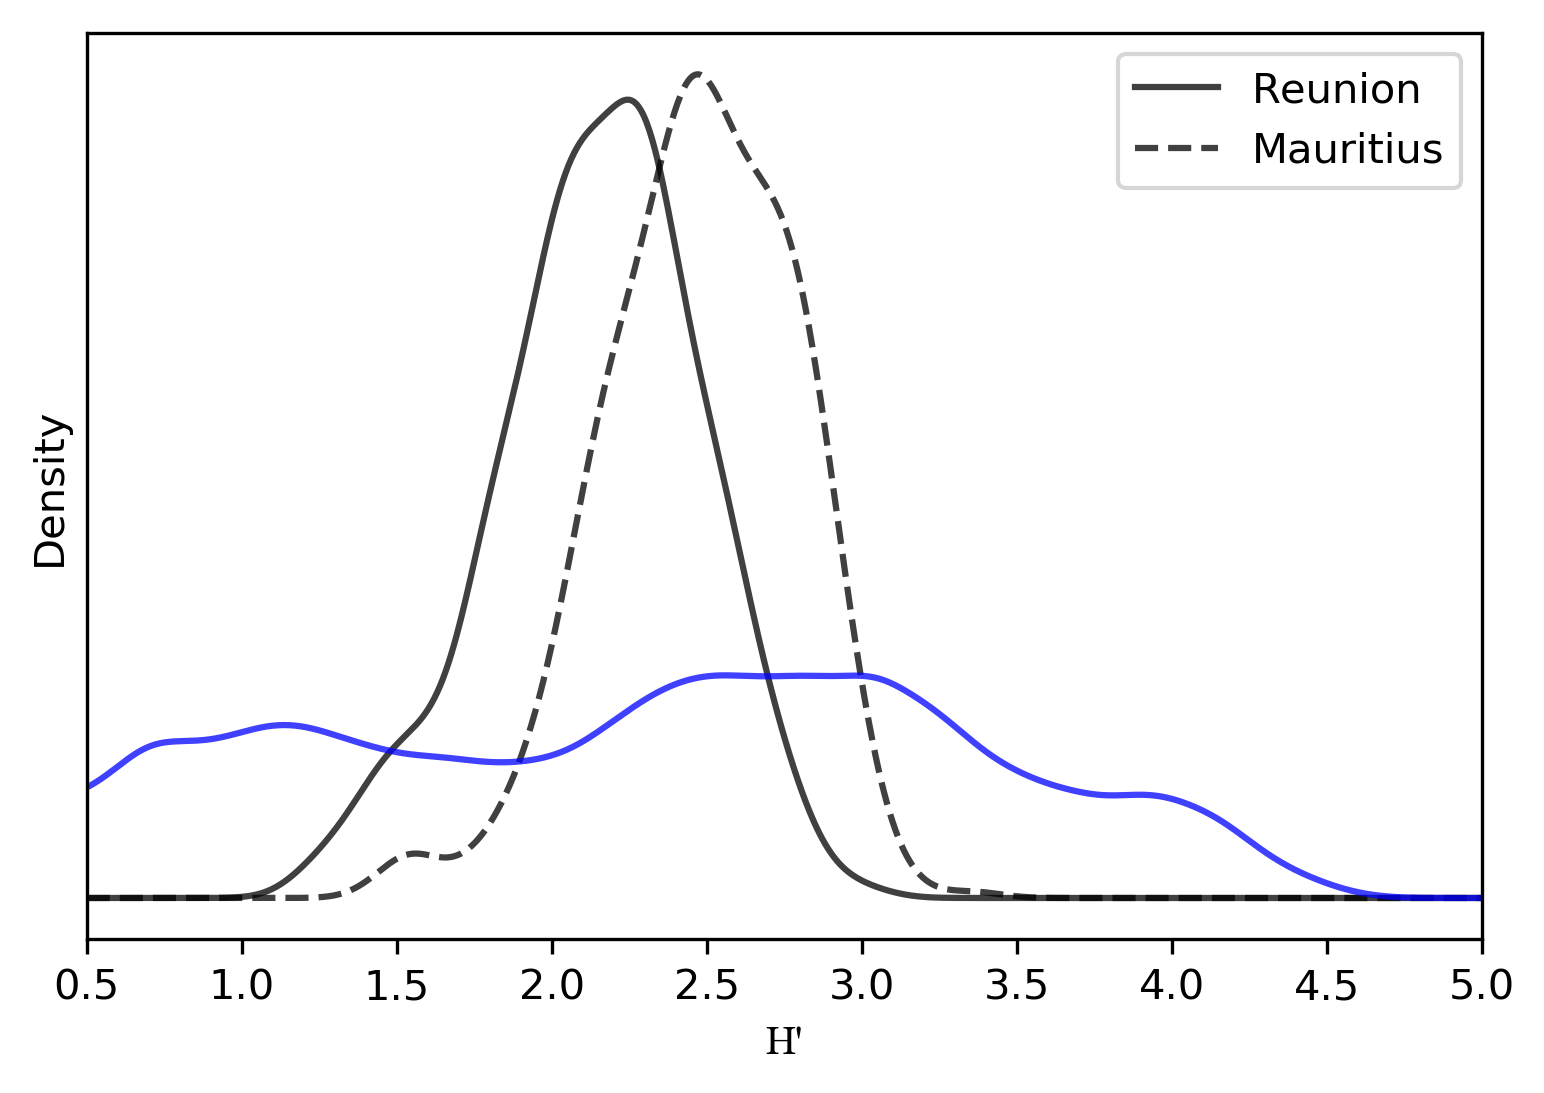

In [290]:
%R -o outm outm=mauritius_shan.abc
%R -o outr outr=reunion_shan.abc
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pymc3
import scipy
import matplotlib
from matplotlib.font_manager import FontProperties
matplotlib.font_manager._rebuild()


## Get shannon prior
f = open(REF_TABLE).readlines()
lines = [line.split("\t") for line in f]

shan_dat = []
for line in lines:
    try:
        shan_dat.append(float(line[6]))
    except:
        pass

shansr = np.array(outr[0]).ravel()
shansm = np.array(outm[0]).ravel()
print(np.mean(shansr), np.mean(shansm))
fig = plt.figure(dpi=300)
plt.rcParams["font.family"] = "Helvetica"

ax = fig.gca()
ax.get_yaxis().set_ticks([])
#_, _, _ = plt.hist(shans, bins=75, color='grey', lw=1, normed=True)

xmin = 0.5
xmax = 5
## KDE
X_plot = np.linspace(xmin, xmax, 1000)
kde = scipy.stats.gaussian_kde(shansr)
plt.plot(X_plot, kde(X_plot), color='black', alpha=0.75, label="Reunion")

kde = scipy.stats.gaussian_kde(shansm)
plt.plot(X_plot, kde(X_plot), color='black', linestyle="--", alpha=0.75, label="Mauritius")

#xs = pymc3.stats.hpd(shans)
#print(xs)
#plt.axvline(xs[0], color='r', linestyle='--', alpha=0.75)
#plt.axvline(xs[1], color='r', linestyle='--', alpha=0.75)
## Truncate to make it look nicer
plt.xlim((xmin, xmax))

#plt.hist(shan_dat, bins=100, histtype="step", normed=True, color='b', alpha=0.75)
X_plot = np.linspace(xmin, xmax, 1000)
kde = scipy.stats.gaussian_kde(shan_dat)
plt.plot(X_plot, kde(X_plot), color='blue', alpha=0.75)

font.set_family('Times New Roman')
plt.xlabel(u"H'", fontproperties=font)
plt.ylabel(u"Density")

plt.legend()
#plt.savefig("/home/isaac/gimmeSAD/spider-shannon-posterior.svg")

Call: 
abc(target = R_OBS, param = data.frame(shan = PRIOR[, "colrate"]), 
    sumstat = PRIOR[, 8:17], tol = 0.001, method = "rejection", 
    numnet = 30, lambda = 0.01)
Data:
 abc.out$unadj.values (1027 posterior samples)

               shan
Min.:        0.0001
2.5% Perc.:  0.0001
Median:      0.0003
Mean:        0.0004
Mode:        0.0003
97.5% Perc.: 0.0009
Max.:        0.0021
                     shan
Min.:        9.417706e-05
2.5% Perc.:  1.469897e-04
Median:      3.313380e-04
Mean:        3.759549e-04
Mode:        2.856680e-04
97.5% Perc.: 8.609775e-04
Max.:        2.126923e-03
Call: 
abc(target = M_OBS, param = data.frame(shan = PRIOR[, "colrate"]), 
    sumstat = PRIOR[, 8:17], tol = 0.001, method = "rejection", 
    numnet = 30, lambda = 0.01)
Data:
 abc.out$unadj.values (1027 posterior samples)

              shan
Min.:        1e-04
2.5% Perc.:  2e-04
Median:      4e-04
Mean:        4e-04
Mode:        3e-04
97.5% Perc.: 1e-03
Max.:        2e-03
                     shan
Mi

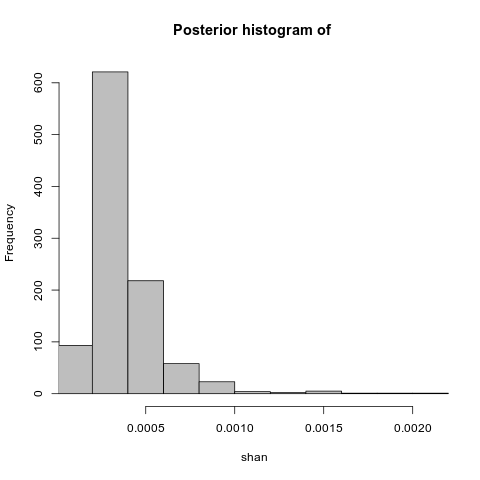

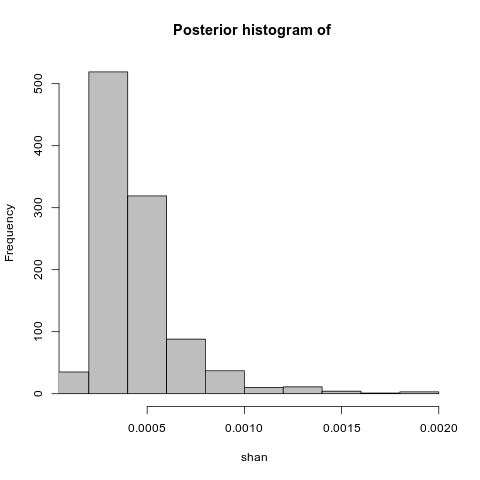

In [261]:
%%R
reunion_col.abc = abc(target=R_OBS, param=data.frame(shan=PRIOR[,"colrate"]), sumstat=PRIOR[,8:17],
                tol=0.001, method="rejection", numnet=30, lambda=0.01)
print(summary(reunion_col.abc))
hist(reunion_col.abc, cap="", breaks=10)

mauritius_col.abc = abc(target=M_OBS, param=data.frame(shan=PRIOR[,"colrate"]), sumstat=PRIOR[,8:17],
                tol=0.001, method="rejection", numnet=30, lambda=0.01)
print(summary(mauritius_col.abc))
hist(mauritius_col.abc, cap="", breaks=10)

0.0003759549110980461
[0.00012262 0.0007505 ]


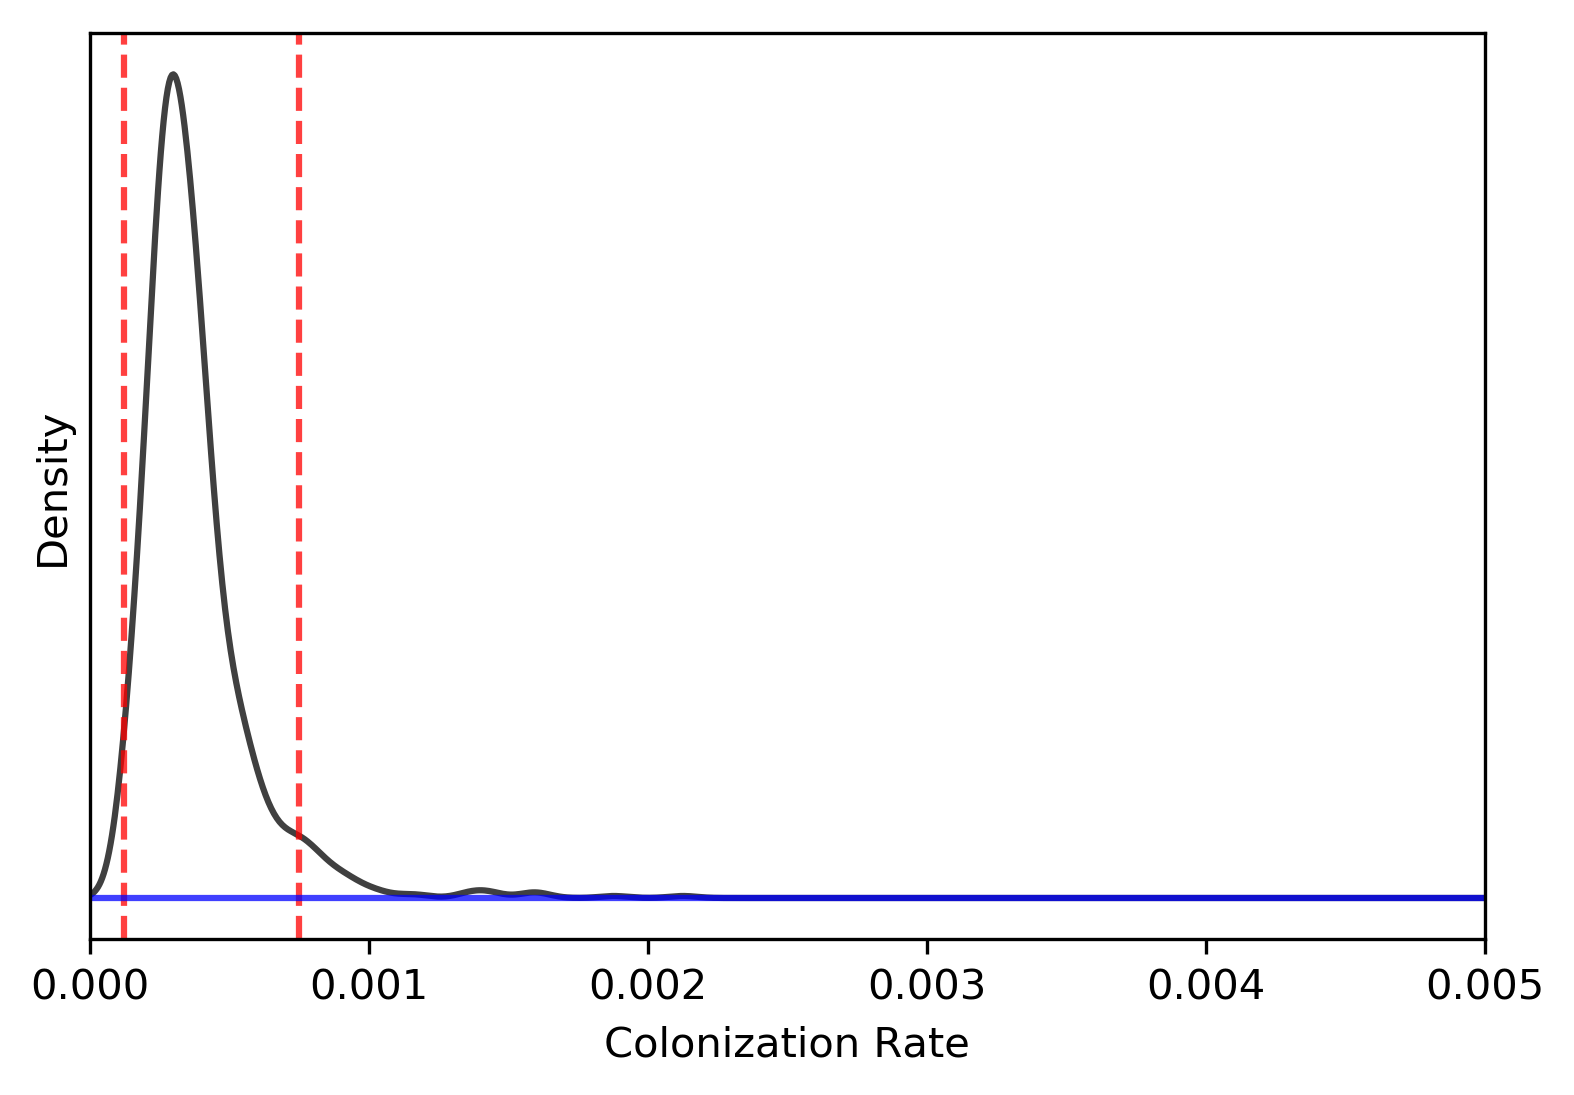

In [262]:
%R -o out out=reunion_col.abc
from sklearn.decomposition import PCA
import scipy
import matplotlib.pyplot as plt
import pymc3
import matplotlib
from matplotlib.font_manager import FontProperties
matplotlib.font_manager._rebuild()

## Get lambda prior
f = open(REF_TABLE).readlines()
lines = [line.split("\t") for line in f]
lamb_dat = []
for line in lines:
    try:
        lamb_dat.append(float(line[1]))
    except:
        pass
#n, bins, patches = plt.hist(lamb_dat, bins=50, histtype="step", normed=True)

## Read in observed data

#print(out.shape)
eqs = np.array(out[0])
eqs = eqs[eqs <= 1.0]
print(np.mean(eqs))
fig = plt.figure(dpi=300)
plt.rcParams["font.family"] = "Helvetica"

ax = fig.gca()
ax.get_yaxis().set_ticks([])

## Histogram of posterior samples
#_, _, _ = plt.hist(eqs, bins=75, color='grey', lw=1, normed=True)

## KDE
xmin = 0
xmax = 0.005
X_plot = np.linspace(xmin, xmax, 1000)
kde = scipy.stats.gaussian_kde(eqs)
plt.plot(X_plot, kde(X_plot), alpha=0.75, color='black')

## HPD
xs = pymc3.stats.hpd(eqs)
print(xs)
plt.axvline(xs[0], color='r', linestyle='--', alpha=0.75)
plt.axvline(xs[1], color='r', linestyle='--', alpha=0.75)

font = FontProperties()
font.set_family('Times New Roman')
plt.xlabel(u"Colonization Rate")
plt.ylabel(u"Density")
## Truncate to show all or part of prior
plt.xlim((0, xmax))
#plt.ylim((0,0.01))

#plt.hist(lamb_dat, bins=50, histtype="step", normed=True, color='b', alpha=0.75)
X_plot = np.linspace(xmin, xmax, 1000)
kde = scipy.stats.gaussian_kde(shan_dat)
plt.plot(X_plot, kde(X_plot), color='blue', alpha=0.75)

#plt.savefig("/home/isaac/gimmeSAD/spider-colrate-posterior.svg")

0.00043948266711809345
[0.00012114 0.00085496]


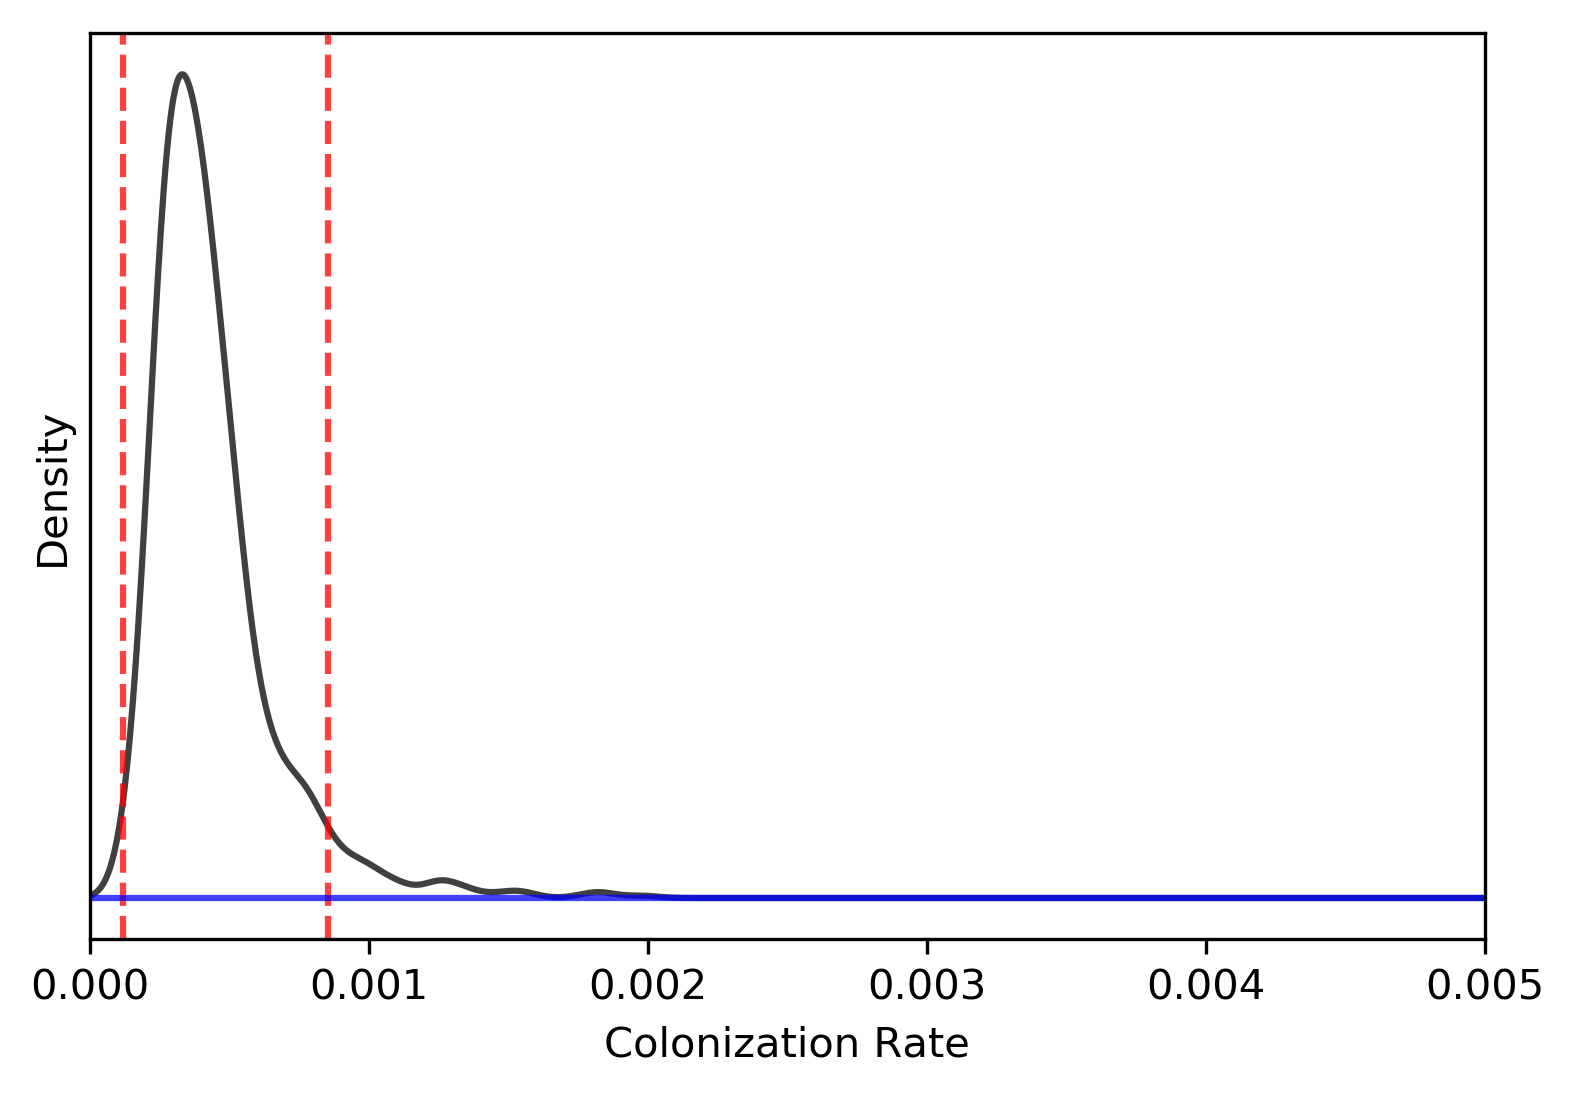

In [263]:
%R -o out out=mauritius_col.abc
from sklearn.decomposition import PCA
import scipy
import matplotlib.pyplot as plt
import pymc3
import matplotlib
from matplotlib.font_manager import FontProperties
matplotlib.font_manager._rebuild()

## Get lambda prior
f = open(REF_TABLE).readlines()
lines = [line.split("\t") for line in f]
lamb_dat = []
for line in lines:
    try:
        lamb_dat.append(float(line[1]))
    except:
        pass
#n, bins, patches = plt.hist(lamb_dat, bins=50, histtype="step", normed=True)

## Read in observed data

#print(out.shape)
eqs = np.array(out[0])
eqs = eqs[eqs <= 1.0]
print(np.mean(eqs))
fig = plt.figure(dpi=300)
plt.rcParams["font.family"] = "Helvetica"

ax = fig.gca()
ax.get_yaxis().set_ticks([])

## Histogram of posterior samples
#_, _, _ = plt.hist(eqs, bins=75, color='grey', lw=1, normed=True)

## KDE
xmin = 0
xmax = 0.005
X_plot = np.linspace(xmin, xmax, 1000)
kde = scipy.stats.gaussian_kde(eqs)
plt.plot(X_plot, kde(X_plot), alpha=0.75, color='black')

## HPD
xs = pymc3.stats.hpd(eqs)
print(xs)
plt.axvline(xs[0], color='r', linestyle='--', alpha=0.75)
plt.axvline(xs[1], color='r', linestyle='--', alpha=0.75)

font = FontProperties()
font.set_family('Times New Roman')
plt.xlabel(u"Colonization Rate")
plt.ylabel(u"Density")
## Truncate to show all or part of prior
plt.xlim((0, xmax))
#plt.ylim((0,0.01))

#plt.hist(lamb_dat, bins=50, histtype="step", normed=True, color='b', alpha=0.75)
X_plot = np.linspace(xmin, xmax, 1000)
kde = scipy.stats.gaussian_kde(shan_dat)
plt.plot(X_plot, kde(X_plot), color='blue', alpha=0.75)

#plt.savefig("/home/isaac/gimmeSAD/spider-colrate-posterior.svg")

Call: 
abc(target = R_OBS, param = data.frame(shan = PRIOR[, "extrate"]), 
    sumstat = PRIOR[, 8:17], tol = 0.001, method = "rejection", 
    numnet = 30, lambda = 0.01)
Data:
 abc.out$unadj.values (1027 posterior samples)

               shan
Min.:        0.0001
2.5% Perc.:  0.0001
Median:      0.0003
Mean:        0.0004
Mode:        0.0003
97.5% Perc.: 0.0008
Max.:        0.0021
                     shan
Min.:        9.405823e-05
2.5% Perc.:  1.465427e-04
Median:      3.286748e-04
Mean:        3.710662e-04
Mode:        2.844678e-04
97.5% Perc.: 8.434767e-04
Max.:        2.076923e-03
Call: 
abc(target = M_OBS, param = data.frame(shan = PRIOR[, "extrate"]), 
    sumstat = PRIOR[, 8:17], tol = 0.001, method = "rejection", 
    numnet = 30, lambda = 0.01)
Data:
 abc.out$unadj.values (1027 posterior samples)

               shan
Min.:        0.0001
2.5% Perc.:  0.0002
Median:      0.0004
Mean:        0.0004
Mode:        0.0003
97.5% Perc.: 0.0010
Max.:        0.0019
                    

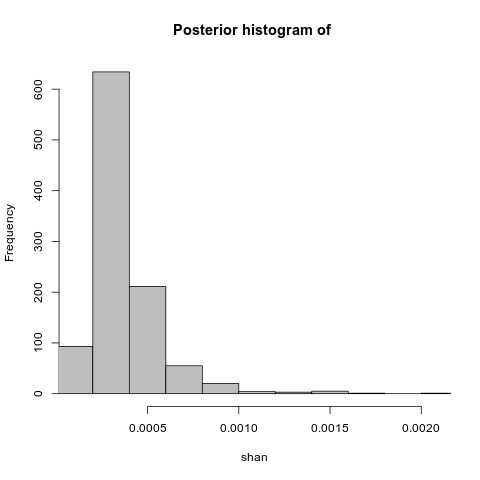

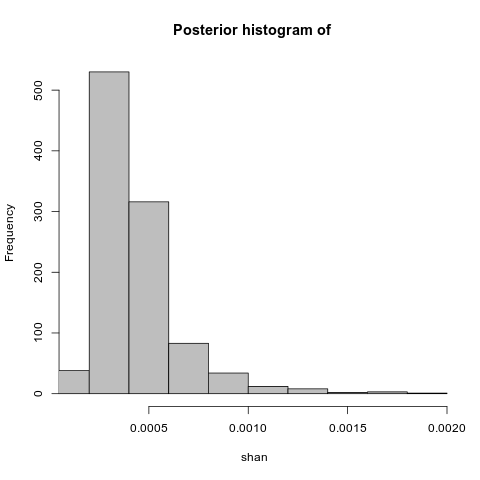

In [264]:
%%R
reunion_ext.abc = abc(target=R_OBS, param=data.frame(shan=PRIOR[,"extrate"]), sumstat=PRIOR[,8:17],
                tol=0.001, method="rejection", numnet=30, lambda=0.01)
print(summary(reunion_ext.abc))
hist(reunion_ext.abc, cap="", breaks=10)

mauritius_ext.abc = abc(target=M_OBS, param=data.frame(shan=PRIOR[,"extrate"]), sumstat=PRIOR[,8:17],
                tol=0.001, method="rejection", numnet=30, lambda=0.01)
print(summary(mauritius_ext.abc))
hist(mauritius_ext.abc, cap="", breaks=10)

0.0003710661800914414
[0.00011967 0.00073819]


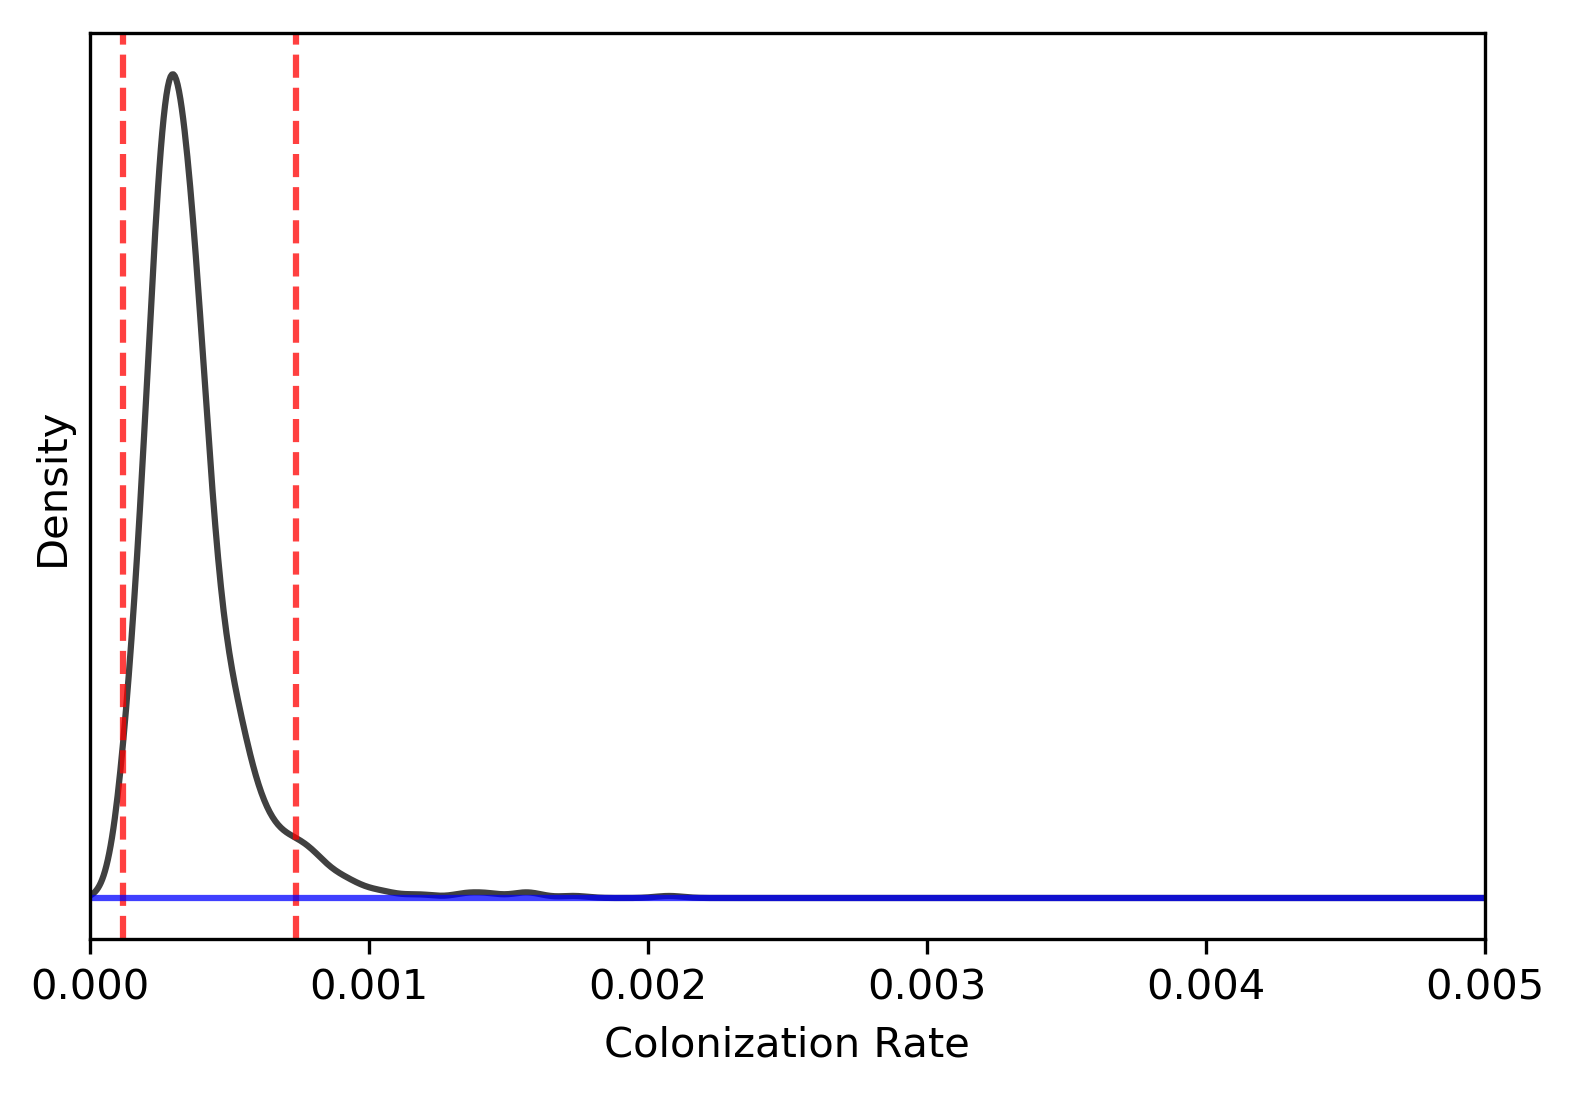

In [265]:
%R -o out out=reunion_ext.abc
from sklearn.decomposition import PCA
import scipy
import matplotlib.pyplot as plt
import pymc3
import matplotlib
from matplotlib.font_manager import FontProperties
matplotlib.font_manager._rebuild()

## Get lambda prior
f = open(REF_TABLE).readlines()
lines = [line.split("\t") for line in f]
lamb_dat = []
for line in lines:
    try:
        lamb_dat.append(float(line[1]))
    except:
        pass
#n, bins, patches = plt.hist(lamb_dat, bins=50, histtype="step", normed=True)

## Read in observed data

#print(out.shape)
eqs = np.array(out[0])
eqs = eqs[eqs <= 1.0]
print(np.mean(eqs))
fig = plt.figure(dpi=300)
plt.rcParams["font.family"] = "Helvetica"

ax = fig.gca()
ax.get_yaxis().set_ticks([])

## Histogram of posterior samples
#_, _, _ = plt.hist(eqs, bins=75, color='grey', lw=1, normed=True)

## KDE
xmin = 0
xmax = 0.005
X_plot = np.linspace(xmin, xmax, 1000)
kde = scipy.stats.gaussian_kde(eqs)
plt.plot(X_plot, kde(X_plot), alpha=0.75, color='black')

## HPD
xs = pymc3.stats.hpd(eqs)
print(xs)
plt.axvline(xs[0], color='r', linestyle='--', alpha=0.75)
plt.axvline(xs[1], color='r', linestyle='--', alpha=0.75)

font = FontProperties()
font.set_family('Times New Roman')
plt.xlabel(u"Colonization Rate")
plt.ylabel(u"Density")
## Truncate to show all or part of prior
plt.xlim((0, xmax))
#plt.ylim((0,0.01))

#plt.hist(lamb_dat, bins=50, histtype="step", normed=True, color='b', alpha=0.75)
X_plot = np.linspace(xmin, xmax, 1000)
kde = scipy.stats.gaussian_kde(shan_dat)
plt.plot(X_plot, kde(X_plot), color='blue', alpha=0.75)

#plt.savefig("/home/isaac/gimmeSAD/spider-colrate-posterior.svg")

0.00043077879988373026
[0.00012087 0.00082609]


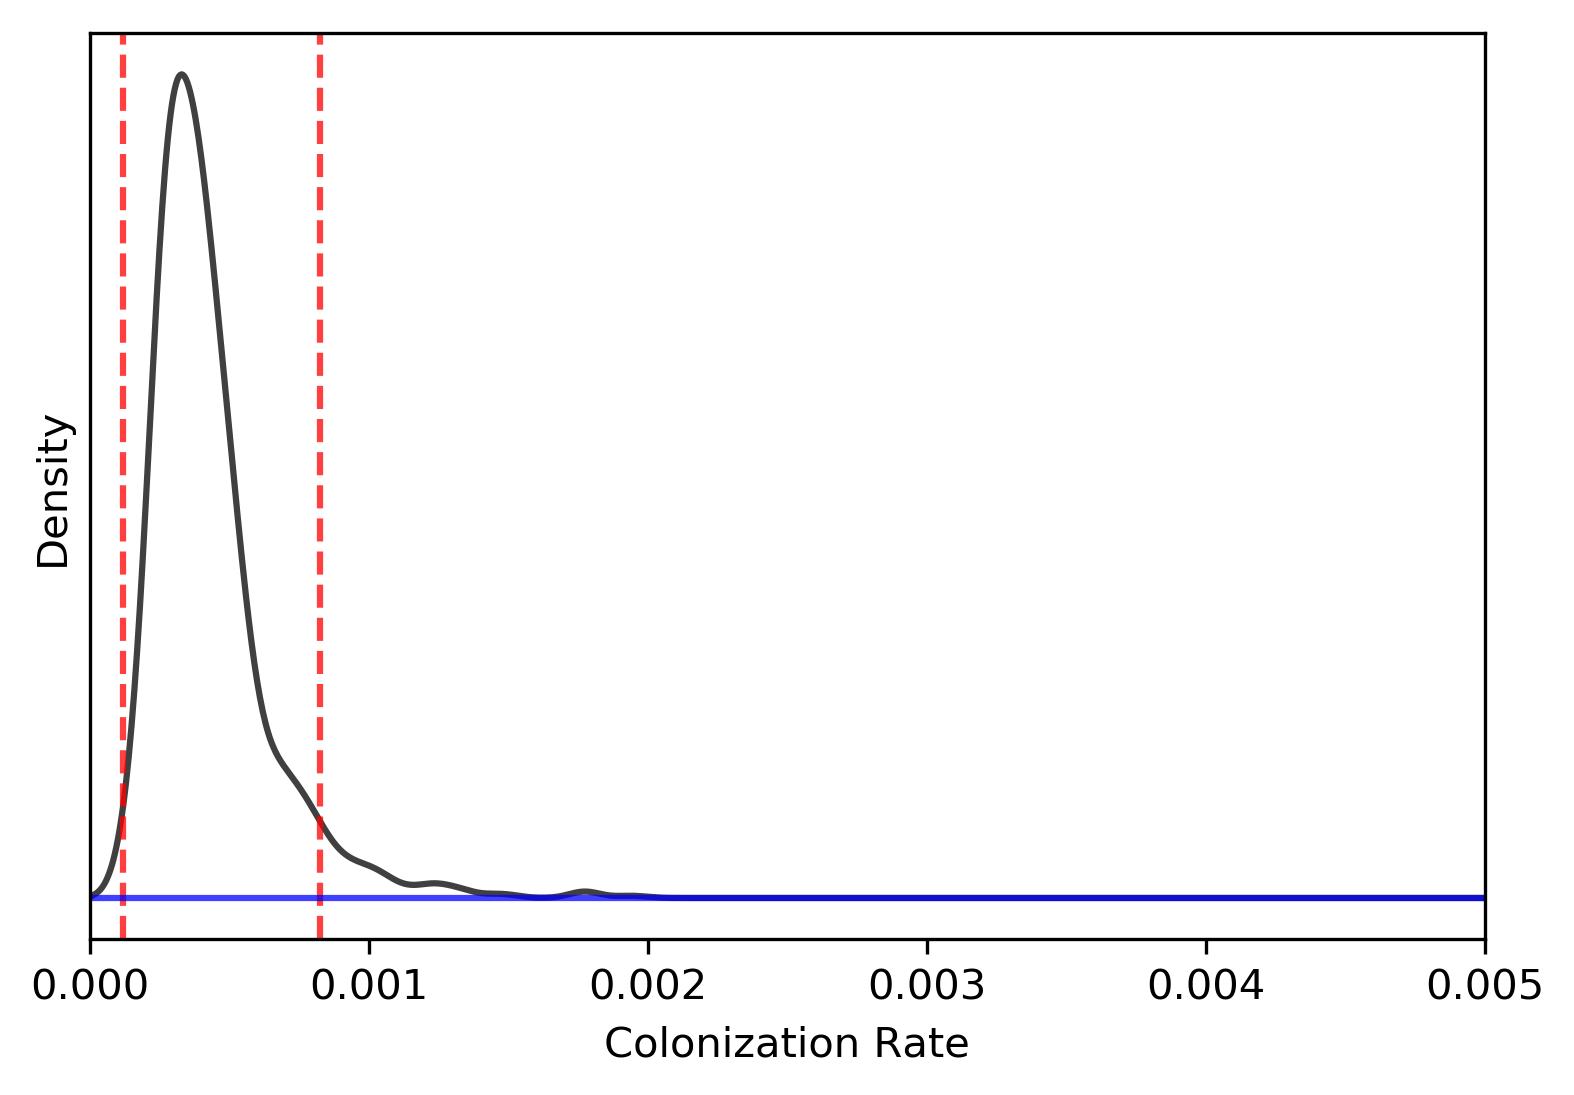

In [266]:
%R -o out out=mauritius_ext.abc
from sklearn.decomposition import PCA
import scipy
import matplotlib.pyplot as plt
import pymc3
import matplotlib
from matplotlib.font_manager import FontProperties
matplotlib.font_manager._rebuild()

## Get lambda prior
f = open(REF_TABLE).readlines()
lines = [line.split("\t") for line in f]
lamb_dat = []
for line in lines:
    try:
        lamb_dat.append(float(line[1]))
    except:
        pass
#n, bins, patches = plt.hist(lamb_dat, bins=50, histtype="step", normed=True)

## Read in observed data

#print(out.shape)
eqs = np.array(out[0])
eqs = eqs[eqs <= 1.0]
print(np.mean(eqs))
fig = plt.figure(dpi=300)
plt.rcParams["font.family"] = "Helvetica"

ax = fig.gca()
ax.get_yaxis().set_ticks([])

## Histogram of posterior samples
#_, _, _ = plt.hist(eqs, bins=75, color='grey', lw=1, normed=True)

## KDE
xmin = 0
xmax = 0.005
X_plot = np.linspace(xmin, xmax, 1000)
kde = scipy.stats.gaussian_kde(eqs)
plt.plot(X_plot, kde(X_plot), alpha=0.75, color='black')

## HPD
xs = pymc3.stats.hpd(eqs)
print(xs)
plt.axvline(xs[0], color='r', linestyle='--', alpha=0.75)
plt.axvline(xs[1], color='r', linestyle='--', alpha=0.75)

font = FontProperties()
font.set_family('Times New Roman')
plt.xlabel(u"Colonization Rate")
plt.ylabel(u"Density")
## Truncate to show all or part of prior
plt.xlim((0, xmax))
#plt.ylim((0,0.01))

#plt.hist(lamb_dat, bins=50, histtype="step", normed=True, color='b', alpha=0.75)
X_plot = np.linspace(xmin, xmax, 1000)
kde = scipy.stats.gaussian_kde(shan_dat)
plt.plot(X_plot, kde(X_plot), color='blue', alpha=0.75)

#plt.savefig("/home/isaac/gimmeSAD/spider-colrate-posterior.svg")

0.0003759549110980461
0.0003710661800914414
[0.00012262 0.0007505 ]
[0.00011967 0.00073819]


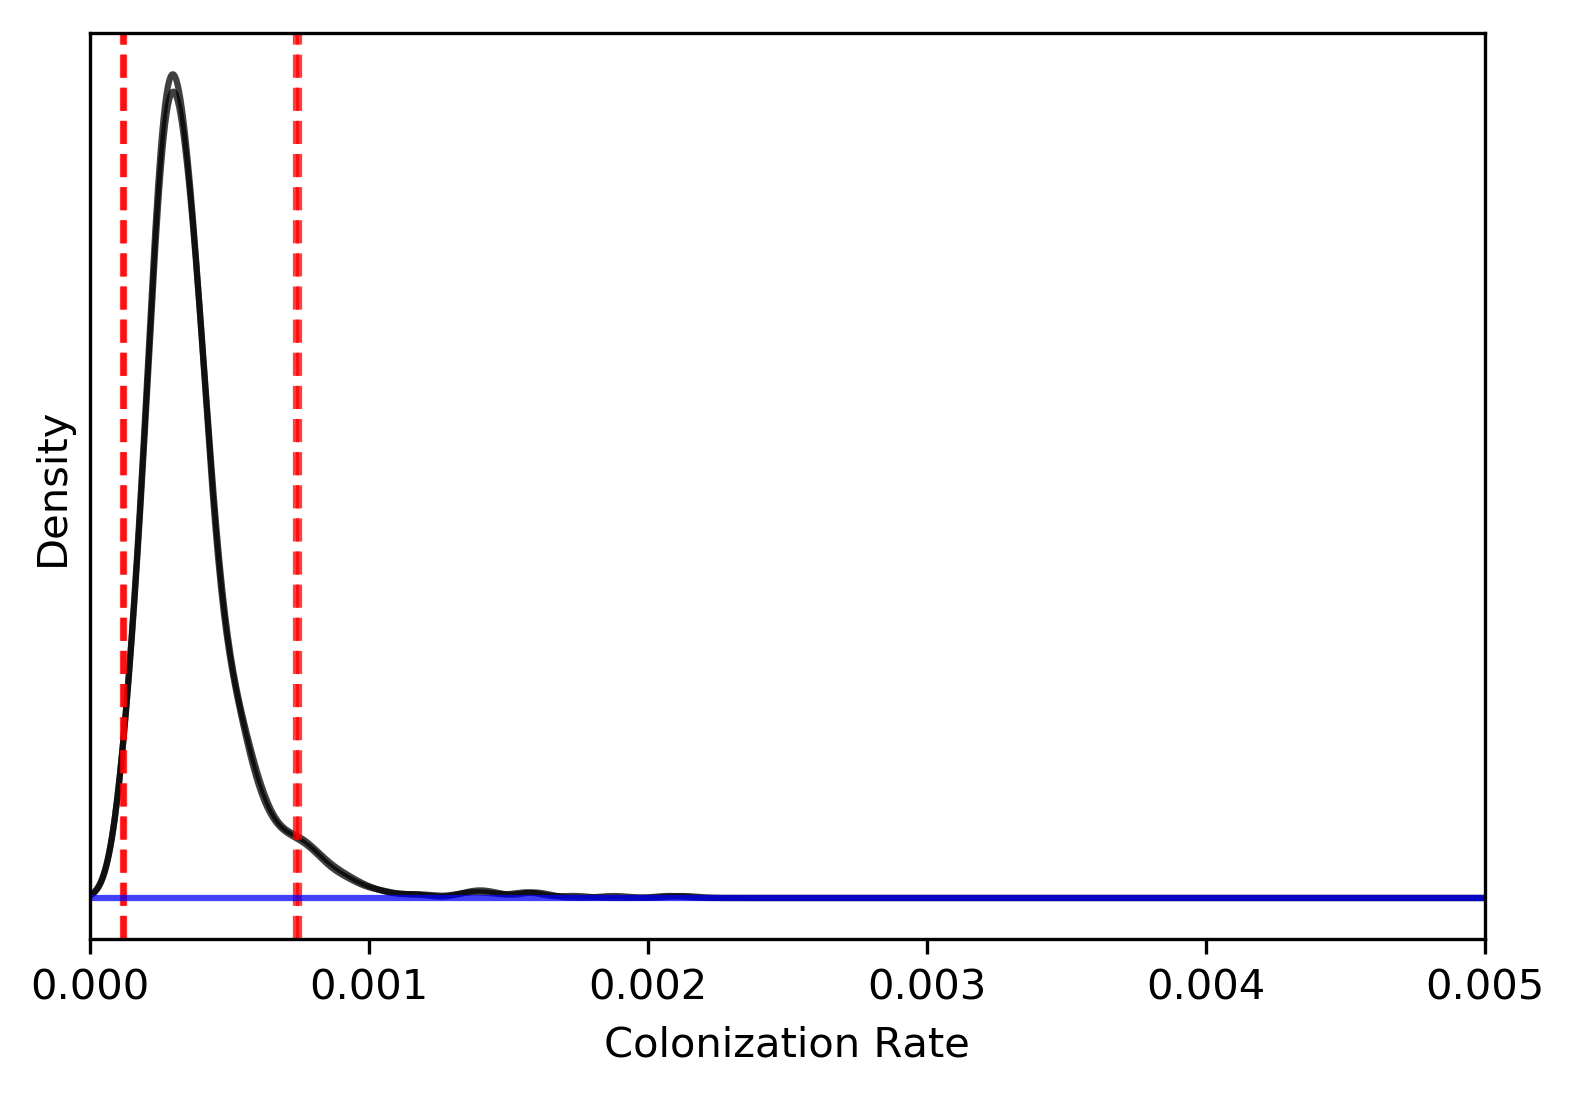

In [267]:
%R -o col col=reunion_col.abc
%R -o ext ext=reunion_ext.abc
from sklearn.decomposition import PCA
import scipy
import matplotlib.pyplot as plt
import pymc3
import matplotlib
from matplotlib.font_manager import FontProperties
matplotlib.font_manager._rebuild()

## Get lambda prior
f = open(REF_TABLE).readlines()
lines = [line.split("\t") for line in f]
lamb_dat = []
for line in lines:
    try:
        lamb_dat.append(float(line[1]))
    except:
        pass
#n, bins, patches = plt.hist(lamb_dat, bins=50, histtype="step", normed=True)

## Read in observed data

#print(out.shape)
cols = np.array(col[0])
cols = cols[cols <= 1.0]
print(np.mean(cols))
exts = np.array(ext[0])
exts = exts[exts <= 1.0]
print(np.mean(exts))

fig = plt.figure(dpi=300)
plt.rcParams["font.family"] = "Helvetica"

ax = fig.gca()
ax.get_yaxis().set_ticks([])

## Histogram of posterior samples
#_, _, _ = plt.hist(eqs, bins=75, color='grey', lw=1, normed=True)

## KDE
xmin = 0
xmax = 0.005
X_plot = np.linspace(xmin, xmax, 1000)
kde = scipy.stats.gaussian_kde(cols)
plt.plot(X_plot, kde(X_plot), alpha=0.75, color='black')
kde = scipy.stats.gaussian_kde(exts)
plt.plot(X_plot, kde(X_plot), alpha=0.75, color='black')

## HPD
xs = pymc3.stats.hpd(cols)
print(xs)
plt.axvline(xs[0], color='r', linestyle='--', alpha=0.75)
plt.axvline(xs[1], color='r', linestyle='--', alpha=0.75)

## HPD
xs = pymc3.stats.hpd(exts)
print(xs)
plt.axvline(xs[0], color='r', linestyle='--', alpha=0.75)
plt.axvline(xs[1], color='r', linestyle='--', alpha=0.75)

font = FontProperties()
font.set_family('Times New Roman')
plt.xlabel(u"Colonization Rate")
plt.ylabel(u"Density")
## Truncate to show all or part of prior
plt.xlim((xmin, xmax))
#plt.ylim((0,0.01))

#plt.hist(lamb_dat, bins=50, histtype="step", normed=True, color='b', alpha=0.75)
X_plot = np.linspace(xmin, xmax, 1000)
kde = scipy.stats.gaussian_kde(shan_dat)
plt.plot(X_plot, kde(X_plot), color='blue', alpha=0.75)

#plt.savefig("/home/isaac/gimmeSAD/spider-colrate-posterior.svg")

0.00043948266711809345
0.00043077879988373026


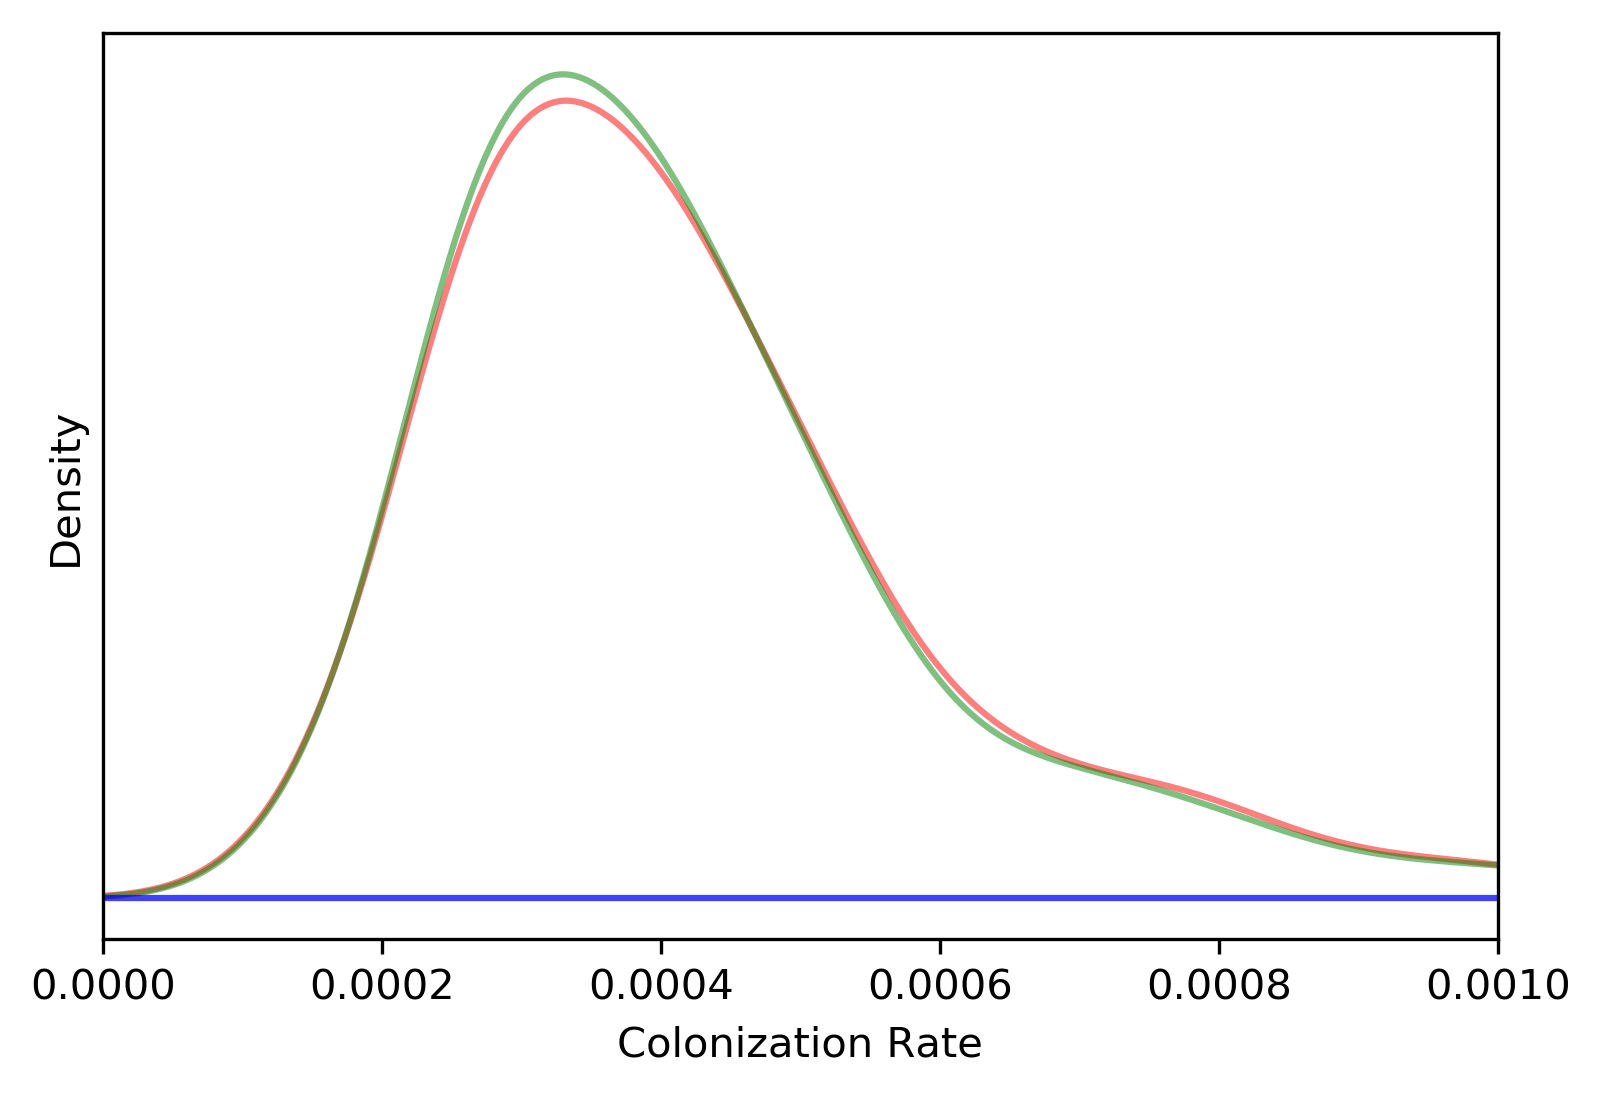

In [268]:
%R -o col col=mauritius_col.abc
%R -o ext ext=mauritius_ext.abc
from sklearn.decomposition import PCA
import scipy
import matplotlib.pyplot as plt
import pymc3
import matplotlib
from matplotlib.font_manager import FontProperties
matplotlib.font_manager._rebuild()

## Get lambda prior
f = open(REF_TABLE).readlines()
lines = [line.split("\t") for line in f]
lamb_dat = []
for line in lines:
    try:
        lamb_dat.append(float(line[1]))
    except:
        pass
#n, bins, patches = plt.hist(lamb_dat, bins=50, histtype="step", normed=True)

## Read in observed data

#print(out.shape)
cols = np.array(col[0])
cols = cols[cols <= 1.0]
print(np.mean(cols))
exts = np.array(ext[0])
exts = exts[exts <= 1.0]
print(np.mean(exts))

fig = plt.figure(dpi=300)
plt.rcParams["font.family"] = "Helvetica"

ax = fig.gca()
ax.get_yaxis().set_ticks([])

## Histogram of posterior samples
#_, _, _ = plt.hist(eqs, bins=75, color='grey', lw=1, normed=True)

## KDE
xmin = 0
xmax = 0.001
X_plot = np.linspace(xmin, xmax, 1000)
kde = scipy.stats.gaussian_kde(cols)
plt.plot(X_plot, kde(X_plot), alpha=0.5, color='red')
kde = scipy.stats.gaussian_kde(exts)
plt.plot(X_plot, kde(X_plot), alpha=0.5, color='green')

## HPD
#xs = pymc3.stats.hpd(cols)
#print(xs)
#plt.axvline(xs[0], color='r', linestyle='--', alpha=0.75)
#plt.axvline(xs[1], color='r', linestyle='--', alpha=0.75)

## HPD
#xs = pymc3.stats.hpd(exts)
#print(xs)
#plt.axvline(xs[0], color='r', linestyle='--', alpha=0.75)
#plt.axvline(xs[1], color='r', linestyle='--', alpha=0.75)

font = FontProperties()
font.set_family('Times New Roman')
plt.xlabel(u"Colonization Rate")
plt.ylabel(u"Density")
## Truncate to show all or part of prior
plt.xlim((xmin, xmax))
#plt.ylim((0,0.01))

#plt.hist(lamb_dat, bins=50, histtype="step", normed=True, color='b', alpha=0.75)
X_plot = np.linspace(xmin, xmax, 1000)
kde = scipy.stats.gaussian_kde(shan_dat)
plt.plot(X_plot, kde(X_plot), color='blue', alpha=0.75)

#plt.savefig("/home/isaac/gimmeSAD/spider-colrate-posterior.svg")

## Jointly estimate all parameters

Hit <Return> to see next plot: 
Hit <Return> to see next plot: 
Hit <Return> to see next plot: 
Hit <Return> to see next plot: 
Hit <Return> to see next plot: 
Hit <Return> to see next plot: 
Hit <Return> to see next plot: 
Hit <Return> to see next plot: 


Call: 
abc(target = R_OBS, param = data.frame(shan = PRIOR[, "shannon"], 
    eq = PRIOR[, "X.equil"], c = PRIOR[, "colrate"], k = PRIOR[, 
        "K"]), sumstat = PRIOR[, 8:17], tol = 0.0025, method = "rejection", 
    hcorr = FALSE)
Data:
 abc.out$unadj.values (983 posterior samples)

                  shan        eq         c         k
Min.:           0.9434    0.0076    0.0001 1623.0000
2.5% Perc.:     1.3424    0.0861    0.0002 3126.3500
Median:         2.1293    0.5969    0.0003 6732.0000
Mean:           2.1161    0.5723    0.0004 6853.2625
Mode:           2.2228    0.8288    0.0003 6244.3215
97.5% Perc.:    2.7430    0.9492    0.0008 9643.0000
Max.:           3.2198    0.9697    0.0022 9643.0000
                     shan           eq            c            k
Min.:        9.434278e-01 7.630467e-03 1.177655e-04 1.623000e+03
2.5% Perc.:  1.342362e+00 8.609196e-02 1.893665e-04 3.126350e+03
Median:      2.129309e+00 5.969409e-01 3.435331e-04 6.732000e+03
Mean:        2.116136e+00 5

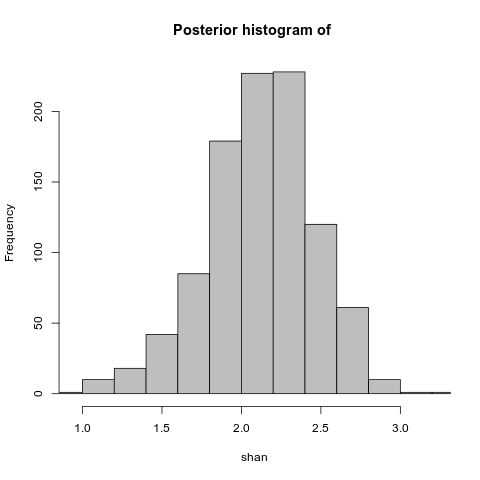

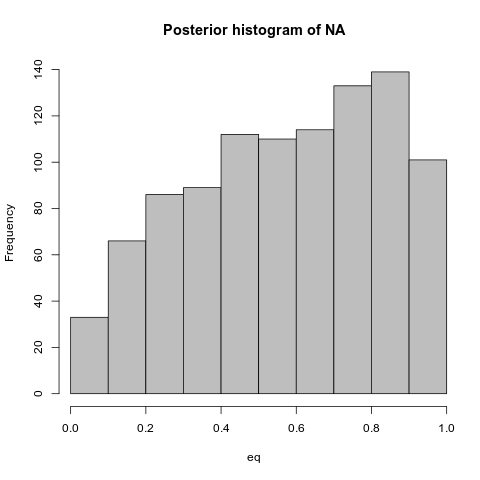

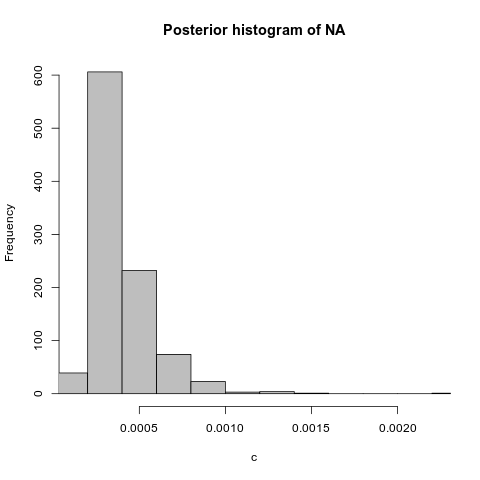

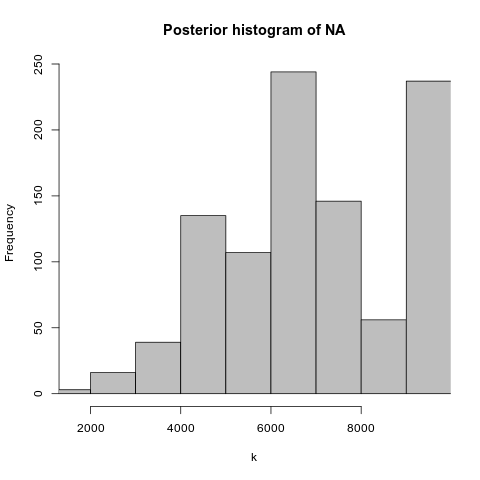

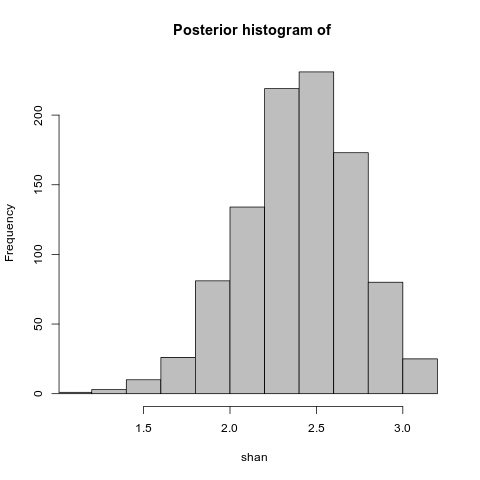

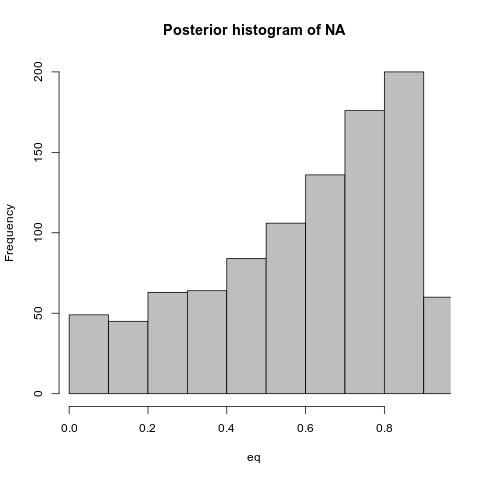

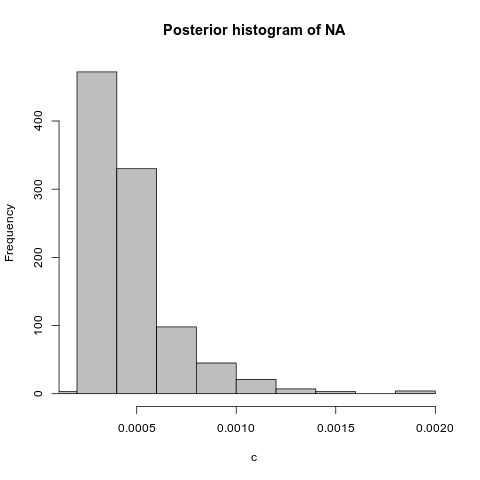

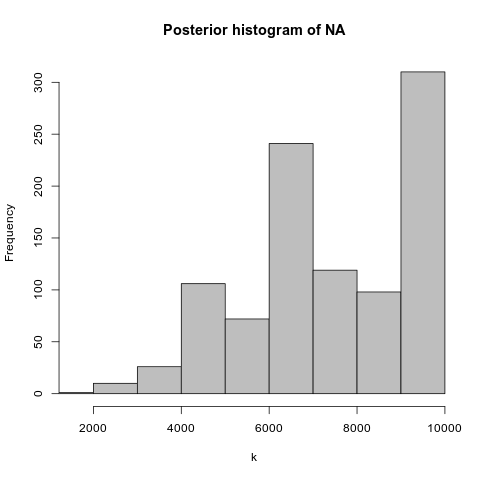

In [216]:
%%R
reunion_joint.abc = abc(target=R_OBS, param=data.frame(shan=PRIOR[,"shannon"], eq=PRIOR[,"X.equil"],
                                                 c=PRIOR[,"colrate"], k=PRIOR[,"K"]), 
                                                 sumstat=PRIOR[,8:17], hcorr=FALSE, tol=0.0025, method="rejection")
print(summary(reunion_joint.abc))
hist(reunion_joint.abc, cap="", breaks=10)

mauritius_joint.abc = abc(target=M_OBS, param=data.frame(shan=PRIOR[,"shannon"], eq=PRIOR[,"X.equil"],
                                                 c=PRIOR[,"colrate"], k=PRIOR[,"K"]), 
                                                 sumstat=PRIOR[,8:17], hcorr=FALSE, tol=0.0025, method="rejection")
print(summary(mauritius_joint.abc))
hist(mauritius_joint.abc, cap="", breaks=10)


In [162]:
%R print(R_OBS[2:10])

  bin_1 bin_2 bin_3 bin_4 bin_5 bin_6 bin_7 bin_8 bin_9
1     3     2     3     2     2     1     0     0     1


Hit <Return> to see next plot: 
Hit <Return> to see next plot: 
Hit <Return> to see next plot: 
Hit <Return> to see next plot: 
Hit <Return> to see next plot: 
Hit <Return> to see next plot: 
Hit <Return> to see next plot: 
Hit <Return> to see next plot: 


Call: 
abc(target = R_OBS[2:10], param = data.frame(shan = PRIOR[, "shannon"], 
    eq = PRIOR[, "X.equil"], c = PRIOR[, "colrate"], k = PRIOR[, 
        "K"]), sumstat = PRIOR[, 9:17], tol = 5e-04, method = "rejection", 
    hcorr = FALSE)
Data:
 abc.out$unadj.values (514 posterior samples)

                  shan        eq         c         k
Min.:           1.3137    0.0075    0.0001 1623.0000
2.5% Perc.:     1.6579    0.0884    0.0002 3005.9500
Median:         2.3213    0.7015    0.0004 7443.0000
Mean:           2.3353    0.6550    0.0004 7355.3813
Mode:           2.3623    0.8940    0.0003 7258.4326
97.5% Perc.:    3.1337    0.9872    0.0010 9992.0000
Max.:           3.3752    0.9985    0.0019 9992.0000
                     shan           eq            c            k
Min.:        1.313693e+00 7.476636e-03 1.329283e-04 1.623000e+03
2.5% Perc.:  1.657927e+00 8.837320e-02 1.983370e-04 3.005950e+03
Median:      2.321260e+00 7.014747e-01 3.773288e-04 7.443000e+03
Mean:        2.335282e

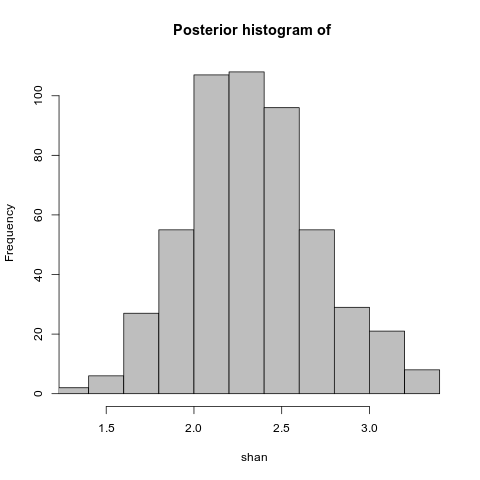

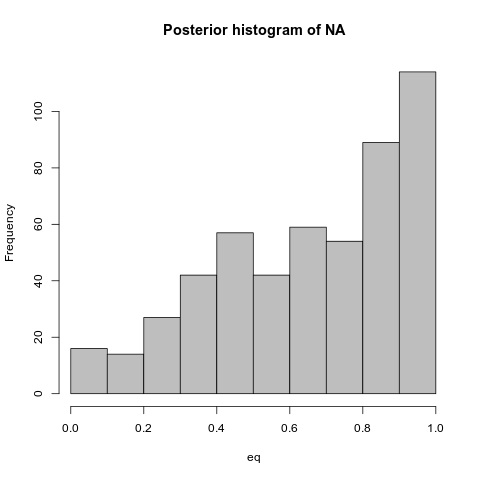

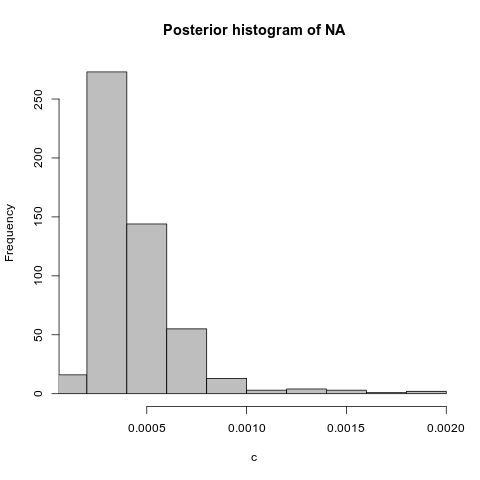

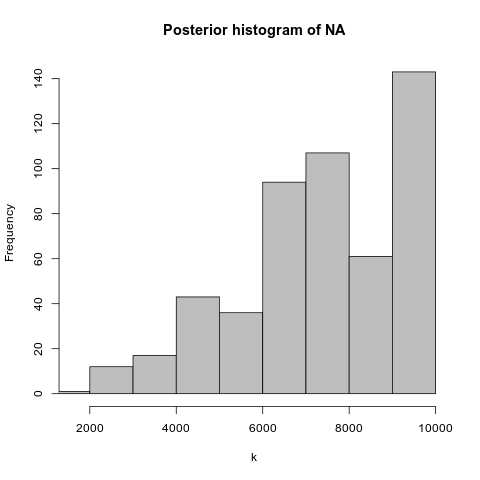

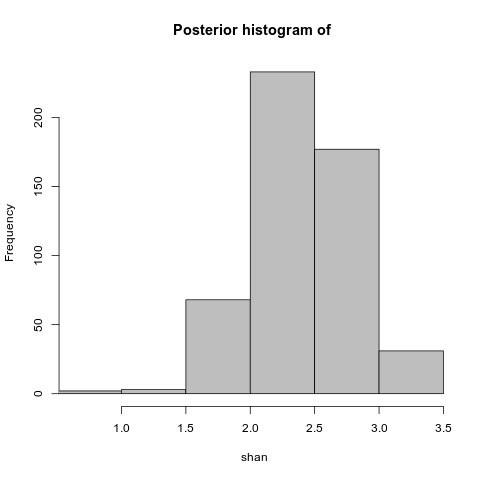

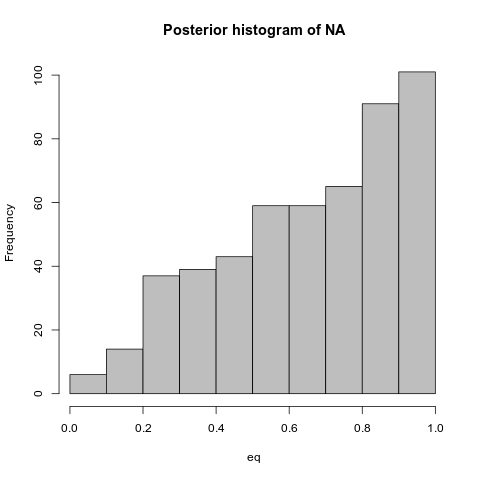

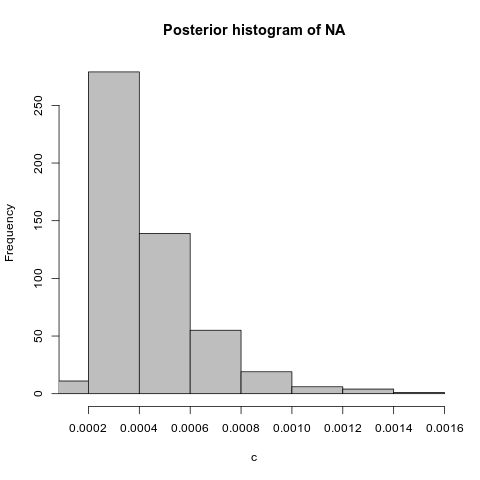

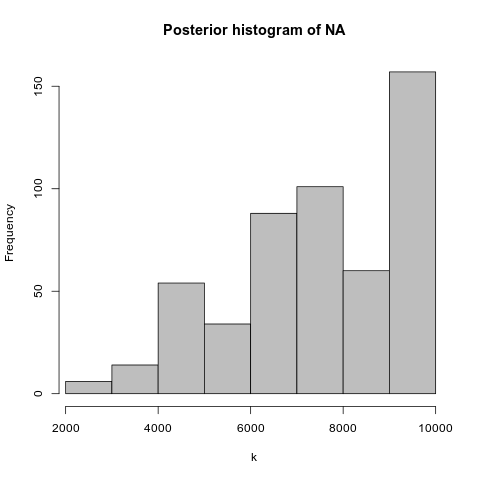

In [270]:
%%R
reunion_joint.abc = abc(target=R_OBS[2:10], param=data.frame(shan=PRIOR[,"shannon"], eq=PRIOR[,"X.equil"],
                                                 c=PRIOR[,"colrate"], k=PRIOR[,"K"]), 
                                                 sumstat=PRIOR[,9:17], hcorr=FALSE, tol=0.0005, method="rejection")
print(summary(reunion_joint.abc))
hist(reunion_joint.abc, cap="", breaks=10)

mauritius_joint.abc = abc(target=M_OBS[2:10], param=data.frame(shan=PRIOR[,"shannon"], eq=PRIOR[,"X.equil"],
                                                 c=PRIOR[,"colrate"], k=PRIOR[,"K"]), 
                                                 sumstat=PRIOR[,9:17], hcorr=FALSE, tol=0.0005, method="rejection")
print(summary(mauritius_joint.abc))
hist(mauritius_joint.abc, cap="", breaks=10)
